In [1]:
import pandas as pd
import numpy as np
from shapely.geometry import LineString
from prediction.data import vessel_groups
from prediction.preprocessing import load_and_build, remove_outliers_parallel
from prediction.preprocessing.trajectory_resampling import compare_trajectory_pairs, resample_trajectories
from prediction.visualization import plot_north_america, plot_trajectories
from dual_autoencoder_utils import *
import shapely
from datetime import timedelta
import matplotlib.pyplot as plt
import dual_autoencoder_utils as utils  # Add this import

# Preparation process
# Step 1: Resample Trajectories
# Step 2: Split into Backward and Forward Trajectories
# Step 3: Normalize Features
# Step 4: Save Data
# Main Function for Data Preparation

# Example usage:
if __name__ == "__main__":
    # Load your train and test DataFrames
    train_df = pd.read_pickle("2024-03-01_2024-03-31_processed.pkl")
    test_df = pd.read_pickle("2024-04-01_2024-04-30_processed.pkl")

    #debug_invalid_line_strings(train_df)
    #debug_invalid_line_strings(test_df)

    # Prepare data
    #backward_train, forward_train, backward_test, forward_test = prepare_data(train_df, test_df)



In [2]:
train_df.head(5)

MMSI                                           geometry         mmsi  \
0  338064000  LINESTRING (-90.20188 29.13611, -90.20186 29.1...  338064000.0   
1  338189000  LINESTRING (-90.25364 28.86053, -90.20885 29.1...  338189000.0   
2  338196000  LINESTRING (-89.33951 28.30381, -89.29135 28.2...  338196000.0   
4  338615000  LINESTRING (-90.21778 29.13023, -90.21781 29.1...  338615000.0   
5  338878000  LINESTRING (-90.19843 29.11397, -90.19844 29.1...  338878000.0   

                                          velocities  \
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
1  [8.8, 5.5, 5.3, 5.3, 5.1, 5.0, 4.9, 4.9, 4.8, ...   
2  [7.3, 7.1, 7.1, 7.3, 7.4, 7.3, 7.3, 7.3, 7.3, ...   
4  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
5  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   

                                        orientations          start_time  \
0  [57.0, 57.0, 57.0, 57.0, 57.0, 57.0, 57.0, 57.... 2024-03-01 00:00:11   
1  [18.4, 349.7, 335.1, 332.8, 330.8, 324.5, 325.... 2024-03-01 03:16:59   
2  [122.0, 150.7, 157.2, 159.2, 160.1, 158.1, 160... 2024-03-01 00:27:44   
4  [138.1, 138.1, 138.1, 138.1, 138.1, 138.1, 138... 2024-03-01 00:03:05   
5  [42.3, 42.3, 42.3, 42.3, 42.3, 42.3, 42.3, 42.... 2024-03-01 00:00:04   

             end_time  point_count vessel_type  \
0 2024-03-01 23:58:51          740       Other   
1 2024-03-01 23:38:57          108       Other   
2 2024-03-01 23:59:44          388       Other   
4 2024-03-01 23:58:52          359       Other   
5 2024-03-01 23:59:23          925       Other   

                                          timestamps  \
0  [2024-03-01 00:00:11, 2024-03-01 00:02:11, 202...   
1  [2024-03-01 03:54:58, 2024-03-01 05:48:16, 202...   
2  [2024-03-01 08:31:34, 2024-03-01 08:58:35, 202...   
4  [2024-03-01 11:31:32, 2024-03-01 11:34:53, 202...   
5  [2024-03-01 00:00:04, 2024-03-01 00:02:24, 202...   

                                            statuses    max_dist  
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   39.241654  
1  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   32.264472  
2  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   19.072855  
4  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  129.390820  
5  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  109.143439

In [3]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3283 entries, 0 to 3679
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   MMSI          3283 non-null   int64         
 1   geometry      3283 non-null   object        
 2   mmsi          3283 non-null   float64       
 3   velocities    3283 non-null   object        
 4   orientations  3283 non-null   object        
 5   start_time    3283 non-null   datetime64[ns]
 6   end_time      3283 non-null   datetime64[ns]
 7   point_count   3283 non-null   int64         
 8   vessel_type   3283 non-null   object        
 9   timestamps    3283 non-null   object        
 10  statuses      3283 non-null   object        
 11  max_dist      3283 non-null   float64       
dtypes: datetime64[ns](2), float64(2), int64(2), object(6)
memory usage: 333.4+ KB



Time Interval Statistics:
       Train Time Intervals  Test Time Intervals
count          1.447868e+06         1.462365e+06
mean           1.281843e+02         1.250592e+02
std            8.886222e+02         8.921957e+02
min            0.000000e+00         0.000000e+00
25%            6.900000e+01         6.900000e+01
50%            7.000000e+01         7.000000e+01
75%            8.000000e+01         8.100000e+01
max            7.874000e+04         7.371300e+04

Trajectory Duration Statistics:
       Train Durations  Test Durations
count      3283.000000     3244.000000
mean      75231.785257    75307.255549
std       18728.678150    18970.050954
min        6871.000000     6970.000000
25%       70466.500000    71359.500000
50%       86058.000000    86211.000000
75%       86344.000000    86347.000000
max       86399.000000    86399.000000

Point Density Statistics:
       Train Point Density  Test Point Density
count          3283.000000         3244.000000
mean              0.006065 

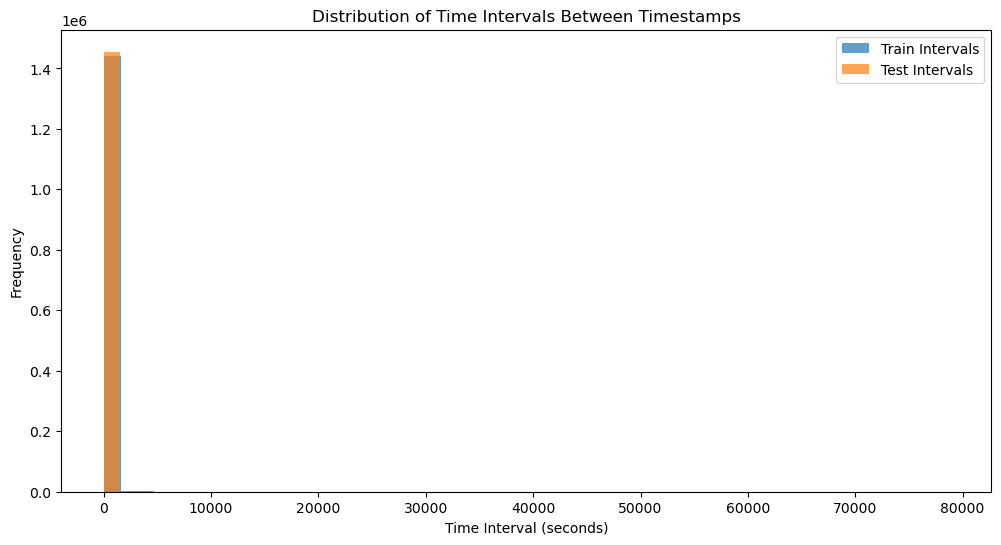

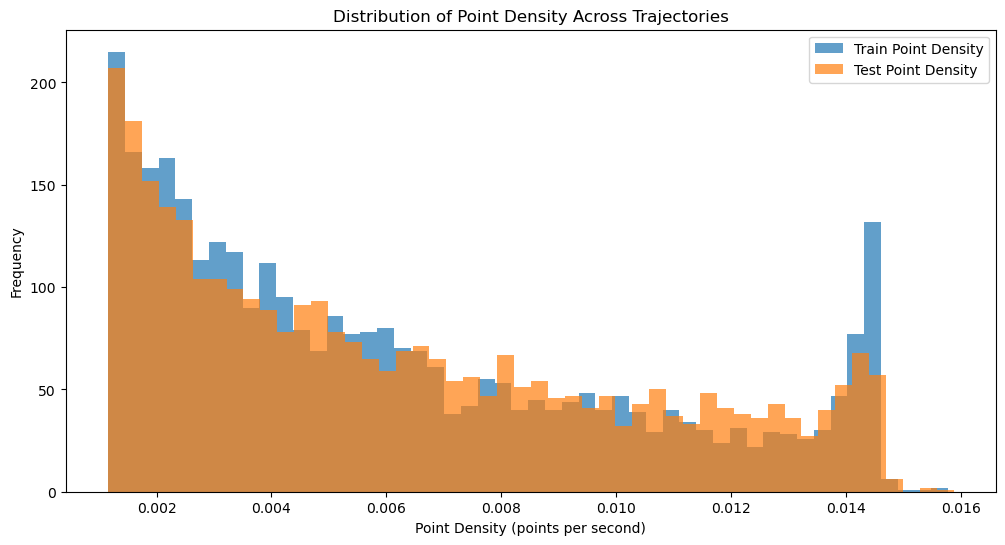

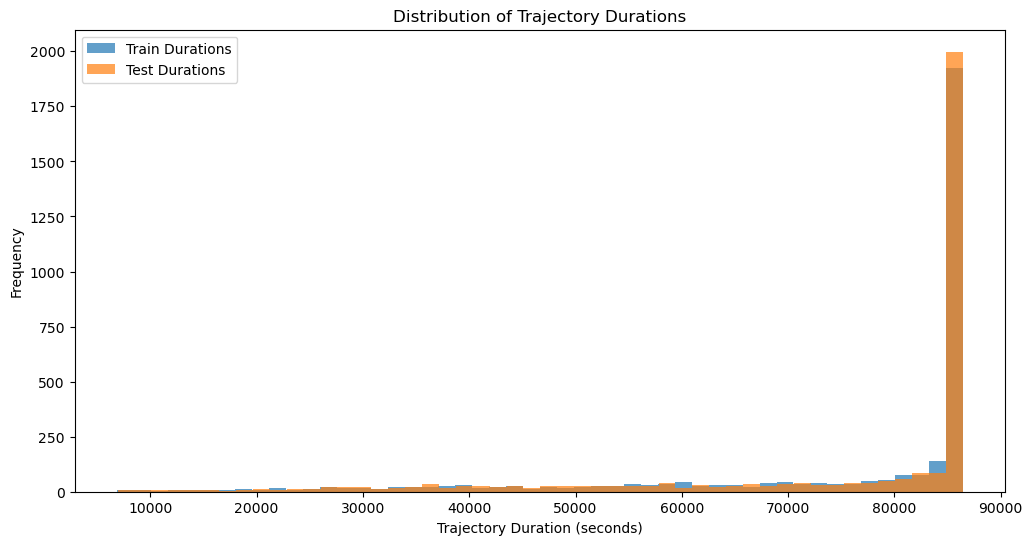

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

# Helper function to calculate time intervals
def calculate_time_intervals(timestamps):
    """Calculate time intervals between consecutive timestamps in seconds."""
    time_intervals = [pd.Series(traj).diff().dt.total_seconds().dropna().tolist() for traj in timestamps]
    return time_intervals

# Calculate time intervals for train and test datasets
train_time_intervals = calculate_time_intervals(train_df["timestamps"])
test_time_intervals = calculate_time_intervals(test_df["timestamps"])

# Flatten time intervals
flat_train_intervals = [item for sublist in train_time_intervals for item in sublist]
flat_test_intervals = [item for sublist in test_time_intervals for item in sublist]

# Numerical statistics for time intervals
train_time_stats = pd.Series(flat_train_intervals).describe()
test_time_stats = pd.Series(flat_test_intervals).describe()

# Add time interval statistics to the DataFrame
time_interval_stats = pd.DataFrame({
    "Train Time Intervals": train_time_stats,
    "Test Time Intervals": test_time_stats
})
print("\nTime Interval Statistics:")
print(time_interval_stats)

# Calculate trajectory duration (in seconds) for train and test datasets
train_df["duration"] = (pd.to_datetime(train_df["end_time"]) - pd.to_datetime(train_df["start_time"])).dt.total_seconds()
test_df["duration"] = (pd.to_datetime(test_df["end_time"]) - pd.to_datetime(test_df["start_time"])).dt.total_seconds()

# Numerical statistics for trajectory durations
train_duration_stats = train_df["duration"].describe()
test_duration_stats = test_df["duration"].describe()

# Add trajectory duration statistics to the DataFrame
duration_stats = pd.DataFrame({
    "Train Durations": train_duration_stats,
    "Test Durations": test_duration_stats
})
print("\nTrajectory Duration Statistics:")
print(duration_stats)

# Calculate point density per trajectory
train_df["point_density"] = train_df["point_count"] / train_df["duration"]
test_df["point_density"] = test_df["point_count"] / test_df["duration"]

# Numerical statistics for point density
point_density_stats = pd.DataFrame({
    "Train Point Density": train_df["point_density"].describe(),
    "Test Point Density": test_df["point_density"].describe()
})
print("\nPoint Density Statistics:")
print(point_density_stats)

# Summary of velocity statistics
train_velocity_stats = train_df["velocities"].apply(lambda x: pd.Series(x).describe()).mean(axis=0)
test_velocity_stats = test_df["velocities"].apply(lambda x: pd.Series(x).describe()).mean(axis=0)

velocity_stats = pd.DataFrame({
    "Train Velocities": train_velocity_stats,
    "Test Velocities": test_velocity_stats
})
print("\nVelocity Statistics:")
print(velocity_stats)

# Summary of orientation statistics
train_orientation_stats = train_df["orientations"].apply(lambda x: pd.Series(x).describe()).mean(axis=0)
test_orientation_stats = test_df["orientations"].apply(lambda x: pd.Series(x).describe()).mean(axis=0)

orientation_stats = pd.DataFrame({
    "Train Orientations": train_orientation_stats,
    "Test Orientations": test_orientation_stats
})
print("\nOrientation Statistics:")
print(orientation_stats)

# Visualize distribution of time intervals
plt.figure(figsize=(12, 6))
plt.hist(flat_train_intervals, bins=50, alpha=0.7, label="Train Intervals")
plt.hist(flat_test_intervals, bins=50, alpha=0.7, label="Test Intervals")
plt.xlabel("Time Interval (seconds)")
plt.ylabel("Frequency")
plt.title("Distribution of Time Intervals Between Timestamps")
plt.legend()
plt.show()

# Visualize point density
plt.figure(figsize=(12, 6))
plt.hist(train_df["point_density"], bins=50, alpha=0.7, label="Train Point Density")
plt.hist(test_df["point_density"], bins=50, alpha=0.7, label="Test Point Density")
plt.xlabel("Point Density (points per second)")
plt.ylabel("Frequency")
plt.title("Distribution of Point Density Across Trajectories")
plt.legend()
plt.show()

# Visualize trajectory duration
plt.figure(figsize=(12, 6))
plt.hist(train_df["duration"], bins=50, alpha=0.7, label="Train Durations")
plt.hist(test_df["duration"], bins=50, alpha=0.7, label="Test Durations")
plt.xlabel("Trajectory Duration (seconds)")
plt.ylabel("Frequency")
plt.title("Distribution of Trajectory Durations")
plt.legend()
plt.show()


In [5]:

# Define the target time interval in seconds
TARGET_INTERVAL = 30


# Apply to your dataframe while retaining the same structure
train_df = train_df.apply(interpolate_trajectory, axis=1)
test_df = test_df.apply(interpolate_trajectory, axis=1)


In [6]:
# Define file paths for saving as pickle
train_pickle_output_path = "train_interpolated.pkl"
test_pickle_output_path = "test_interpolated.pkl"

# Save DataFrames as pickle
train_df.to_pickle(train_pickle_output_path)
test_df.to_pickle(test_pickle_output_path)

print(f"Train data saved to {train_pickle_output_path}")
print(f"Test data saved to {test_pickle_output_path}")


Train data saved to train_interpolated.pkl
Test data saved to test_interpolated.pkl


In [7]:
train_df = pd.read_pickle("train_interpolated.pkl")
test_df = pd.read_pickle("test_interpolated.pkl")


Time Interval Statistics:
       Train Time Intervals  Test Time Intervals
count              616888.0             607838.0
mean                  300.0                300.0
std                     0.0                  0.0
min                   300.0                300.0
25%                   300.0                300.0
50%                   300.0                300.0
75%                   300.0                300.0
max                   300.0                300.0

Trajectory Duration Statistics:
       Train Durations  Test Durations
count      3283.000000     3244.000000
mean      75231.785257    75307.255549
std       18728.678150    18970.050954
min        6871.000000     6970.000000
25%       70466.500000    71359.500000
50%       86058.000000    86211.000000
75%       86344.000000    86347.000000
max       86399.000000    86399.000000

Point Density Statistics:
       Train Point Density  Test Point Density
count          3283.000000         3244.000000
mean              0.006065 

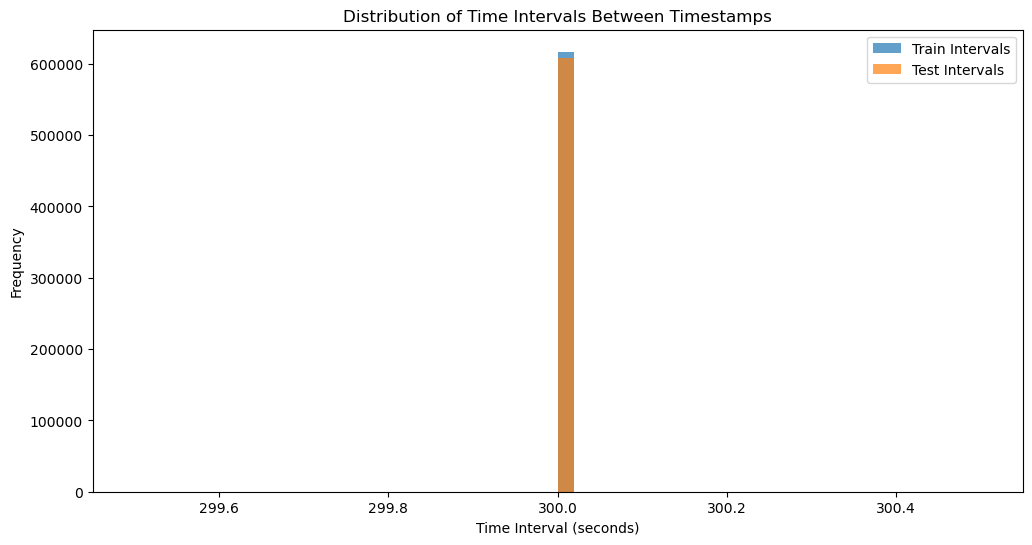

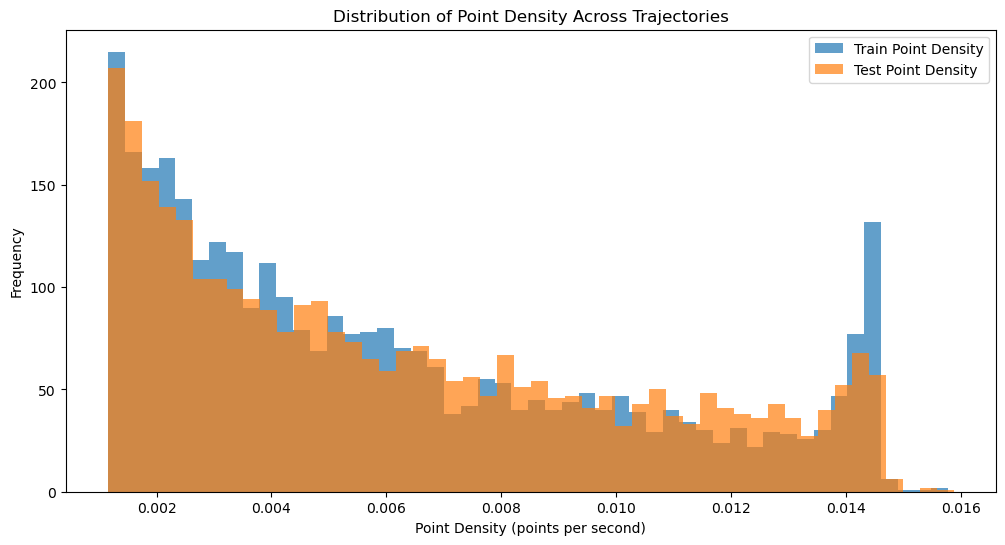

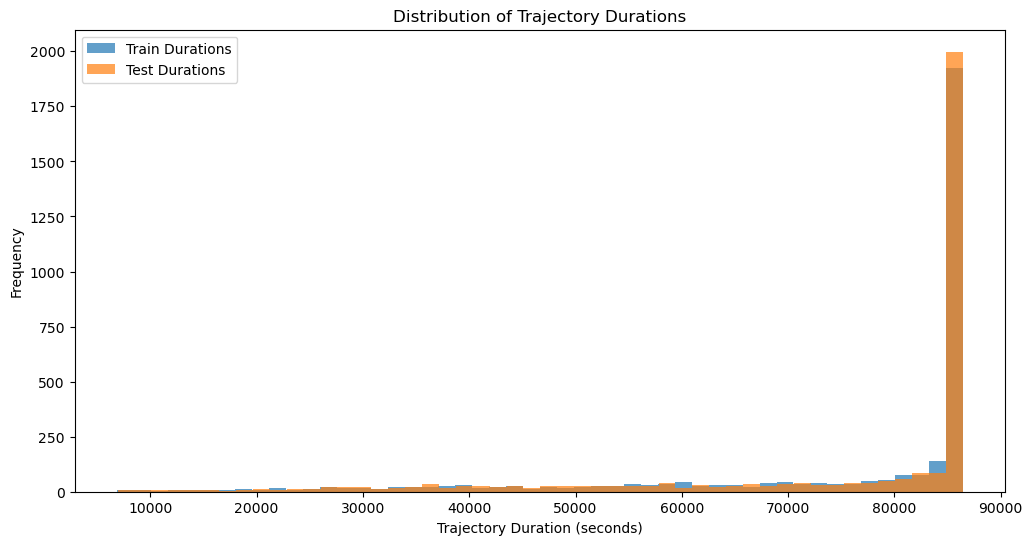

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

# Helper function to calculate time intervals
def calculate_time_intervals(timestamps):
    """Calculate time intervals between consecutive timestamps in seconds."""
    time_intervals = [pd.Series(traj).diff().dt.total_seconds().dropna().tolist() for traj in timestamps]
    return time_intervals

# Calculate time intervals for train and test datasets
train_time_intervals = calculate_time_intervals(train_df["timestamps"])
test_time_intervals = calculate_time_intervals(test_df["timestamps"])

# Flatten time intervals
flat_train_intervals = [item for sublist in train_time_intervals for item in sublist]
flat_test_intervals = [item for sublist in test_time_intervals for item in sublist]

# Numerical statistics for time intervals
train_time_stats = pd.Series(flat_train_intervals).describe()
test_time_stats = pd.Series(flat_test_intervals).describe()

# Add time interval statistics to the DataFrame
time_interval_stats = pd.DataFrame({
    "Train Time Intervals": train_time_stats,
    "Test Time Intervals": test_time_stats
})
print("\nTime Interval Statistics:")
print(time_interval_stats)

# Calculate trajectory duration (in seconds) for train and test datasets
train_df["duration"] = (pd.to_datetime(train_df["end_time"]) - pd.to_datetime(train_df["start_time"])).dt.total_seconds()
test_df["duration"] = (pd.to_datetime(test_df["end_time"]) - pd.to_datetime(test_df["start_time"])).dt.total_seconds()

# Numerical statistics for trajectory durations
train_duration_stats = train_df["duration"].describe()
test_duration_stats = test_df["duration"].describe()

# Add trajectory duration statistics to the DataFrame
duration_stats = pd.DataFrame({
    "Train Durations": train_duration_stats,
    "Test Durations": test_duration_stats
})
print("\nTrajectory Duration Statistics:")
print(duration_stats)

# Calculate point density per trajectory
train_df["point_density"] = train_df["point_count"] / train_df["duration"]
test_df["point_density"] = test_df["point_count"] / test_df["duration"]

# Numerical statistics for point density
point_density_stats = pd.DataFrame({
    "Train Point Density": train_df["point_density"].describe(),
    "Test Point Density": test_df["point_density"].describe()
})
print("\nPoint Density Statistics:")
print(point_density_stats)

# Summary of velocity statistics
train_velocity_stats = train_df["velocities"].apply(lambda x: pd.Series(x).describe()).mean(axis=0)
test_velocity_stats = test_df["velocities"].apply(lambda x: pd.Series(x).describe()).mean(axis=0)

velocity_stats = pd.DataFrame({
    "Train Velocities": train_velocity_stats,
    "Test Velocities": test_velocity_stats
})
print("\nVelocity Statistics:")
print(velocity_stats)

# Summary of orientation statistics
train_orientation_stats = train_df["orientations"].apply(lambda x: pd.Series(x).describe()).mean(axis=0)
test_orientation_stats = test_df["orientations"].apply(lambda x: pd.Series(x).describe()).mean(axis=0)

orientation_stats = pd.DataFrame({
    "Train Orientations": train_orientation_stats,
    "Test Orientations": test_orientation_stats
})
print("\nOrientation Statistics:")
print(orientation_stats)

# Visualize distribution of time intervals
plt.figure(figsize=(12, 6))
plt.hist(flat_train_intervals, bins=50, alpha=0.7, label="Train Intervals")
plt.hist(flat_test_intervals, bins=50, alpha=0.7, label="Test Intervals")
plt.xlabel("Time Interval (seconds)")
plt.ylabel("Frequency")
plt.title("Distribution of Time Intervals Between Timestamps")
plt.legend()
plt.show()

# Visualize point density
plt.figure(figsize=(12, 6))
plt.hist(train_df["point_density"], bins=50, alpha=0.7, label="Train Point Density")
plt.hist(test_df["point_density"], bins=50, alpha=0.7, label="Test Point Density")
plt.xlabel("Point Density (points per second)")
plt.ylabel("Frequency")
plt.title("Distribution of Point Density Across Trajectories")
plt.legend()
plt.show()

# Visualize trajectory duration
plt.figure(figsize=(12, 6))
plt.hist(train_df["duration"], bins=50, alpha=0.7, label="Train Durations")
plt.hist(test_df["duration"], bins=50, alpha=0.7, label="Test Durations")
plt.xlabel("Trajectory Duration (seconds)")
plt.ylabel("Frequency")
plt.title("Distribution of Trajectory Durations")
plt.legend()
plt.show()


In [9]:
train_df.head(5)

MMSI                                           geometry         mmsi  \
0  338064000  LINESTRING (-90.20188 29.13611, -90.2018734234...  338064000.0   
1  338189000  LINESTRING (-90.25364 28.86053, -90.2096232000...  338189000.0   
2  338196000  LINESTRING (-89.33951 28.30381, -89.2862054594...  338196000.0   
4  338615000  LINESTRING (-90.21778 29.13023, -90.21777 29.1...  338615000.0   
5  338878000  LINESTRING (-90.19843 29.11397, -90.1984451578...  338878000.0   

                                          velocities  \
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.4938271604938...   
1  [8.8, 8.654368932038835, 8.50873786407767, 8.3...   
2  [7.3, 7.262985811227637, 7.225971622455274, 7....   
4  [0.0, 0.0, 0.0, 0.0, 0.0, 0.29666666666666663,...   
5  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   

                                        orientations          start_time  \
0  [57.0, 57.0, 57.0, 57.0, 57.0, 57.0, 239.12345... 2024-03-01 00:00:11   
1  [18.4, 33.02047661076787, 47.640953221535746, ... 2024-03-01 03:16:59   
2  [122.0, 127.31153608883405, 132.6230721776681,... 2024-03-01 00:27:44   
4  [138.1, 138.1, 138.1, 138.1, 138.1, 245.493333... 2024-03-01 00:03:05   
5  [42.3, 42.3, 42.3, 42.3, 42.3, 42.3, 42.3, 42.... 2024-03-01 00:00:04   

             end_time  point_count vessel_type  \
0 2024-03-01 23:58:51          740       Other   
1 2024-03-01 23:38:57          108       Other   
2 2024-03-01 23:59:44          388       Other   
4 2024-03-01 23:58:52          359       Other   
5 2024-03-01 23:59:23          925       Other   

                                          timestamps  \
0  [2024-03-01 00:00:11, 2024-03-01 00:05:11, 202...   
1  [2024-03-01 03:54:58, 2024-03-01 03:59:58, 202...   
2  [2024-03-01 08:31:34, 2024-03-01 08:36:34, 202...   
4  [2024-03-01 11:31:32, 2024-03-01 11:36:32, 202...   
5  [2024-03-01 00:00:04, 2024-03-01 00:05:04, 202...   

                                            statuses    max_dist  duration  \
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   39.241654   86320.0   
1  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   32.264472   73318.0   
2  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   19.072855   84720.0   
4  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  129.390820   86147.0   
5  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  109.143439   86359.0   

   point_density  
0       0.008573  
1       0.001473  
2       0.004580  
4       0.004167  
5       0.010711

In [10]:
test_df.head(5)

MMSI                                           geometry         mmsi  \
0  210328000  LINESTRING (-88.50088 28.15913, -88.5484633333...  210328000.0   
3  303517000  LINESTRING (-89.14979 28.2298, -89.63032634146...  303517000.0   
4  309022000  LINESTRING (-89.65792 28.37638, -89.6583105923...  309022000.0   
5  309022000  LINESTRING (-89.56094 28.34566, -89.5235558333...  309022000.0   
6  311032100  LINESTRING (-89.3843 28.00027, -89.38313794117...  311032100.0   

                                          velocities  \
0  [9.7, 9.105940594059405, 8.511881188118812, 7....   
3  [9.3, 9.23840579710145, 9.1768115942029, 9.115...   
4  [0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, ...   
5  [9.7, 8.23191489361702, 6.763829787234043, 5.2...   
6  [1.3, 1.26, 1.3, 1.4, 1.5449275362318842, 1.49...   

                                        orientations          start_time  \
0  [252.9, 269.5930693069307, 286.2861386138614, ... 2024-04-01 02:02:27   
3  [302.0, 301.94565217391306, 301.89130434782606... 2024-04-01 00:00:05   
4  [309.5, 309.1101449275362, 308.0, 308.41467889... 2024-04-01 00:00:11   
5  [117.1, 114.73829787234042, 112.37659574468086... 2024-04-01 00:00:11   
6  [33.0, 38.2, 30.62295081967213, 23.0, 26.82608... 2024-04-01 12:40:55   

             end_time  point_count vessel_type  \
0 2024-04-01 23:59:17          131       Other   
3 2024-04-01 23:59:46          596       Other   
4 2024-04-01 23:59:50          492       Other   
5 2024-04-01 23:59:50          519       Other   
6 2024-04-01 22:29:45          440       Other   

                                          timestamps  \
0  [2024-04-01 02:02:27, 2024-04-01 02:07:27, 202...   
3  [2024-04-01 03:28:45, 2024-04-01 03:33:45, 202...   
4  [2024-04-01 00:00:11, 2024-04-01 00:05:11, 202...   
5  [2024-04-01 04:43:49, 2024-04-01 04:48:49, 202...   
6  [2024-04-01 12:40:55, 2024-04-01 12:45:55, 202...   

                                            statuses    max_dist  duration  \
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   17.230298   79010.0   
3  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  145.610836   86381.0   
4  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   44.843798   86379.0   
5  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   16.602397   86379.0   
6  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   25.542050   35330.0   

   point_density  
0       0.001658  
3       0.006900  
4       0.005696  
5       0.006008  
6       0.012454

In [11]:

# Constants

# Apply filtering to the DataFrame
final_test_df, filtered_test_dfs = filter_trajectories(test_df)
final_train_df, filtered_train_dfs = filter_trajectories(train_df)


initial_df = filtered_train_dfs["initial"]
after_nans_df = filtered_train_dfs["after_dropping_nans"]
duration_filtered_df = filtered_train_dfs["after_duration_filter"]
point_density_filtered_df = filtered_train_dfs["after_point_density_filter"]
velocity_filtered_df = filtered_train_dfs["after_velocity_filter"]


In [12]:
# Define file paths for saving as pickle
train_pickle_output_path = "train_cleaned_interpolated.pkl"
test_pickle_output_path = "test_cleaned_interpolated.pkl"

# Save DataFrames as pickle
final_train_df.to_pickle(train_pickle_output_path)
final_test_df.to_pickle(test_pickle_output_path)

print(f"Train data saved to {train_pickle_output_path}")
print(f"Test data saved to {test_pickle_output_path}")


Train data saved to train_cleaned_interpolated.pkl
Test data saved to test_cleaned_interpolated.pkl


In [13]:
train_df = pd.read_pickle("train_cleaned_interpolated.pkl")
test_df = pd.read_pickle("test_cleaned_interpolated.pkl")


Time Interval Statistics:
       Train Time Intervals  Test Time Intervals
count              421165.0             438083.0
mean                  300.0                300.0
std                     0.0                  0.0
min                   300.0                300.0
25%                   300.0                300.0
50%                   300.0                300.0
75%                   300.0                300.0
max                   300.0                300.0

Trajectory Duration Statistics:
       Train Durations  Test Durations
count      2354.000000     2428.000000
mean      72833.147833    73155.672158
std       20239.591185    20398.467109
min        6871.000000     6970.000000
25%       63582.500000    64363.250000
50%       85282.500000    85980.000000
75%       86331.000000    86339.000000
max       86399.000000    86399.000000

Point Density Statistics:
       Train Point Density  Test Point Density
count          2354.000000         2428.000000
mean              0.002506 

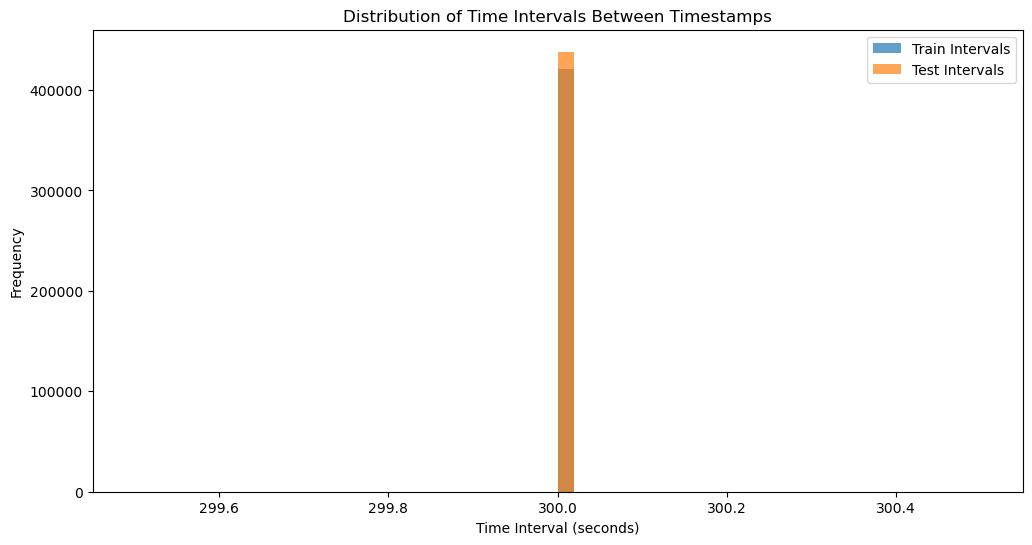

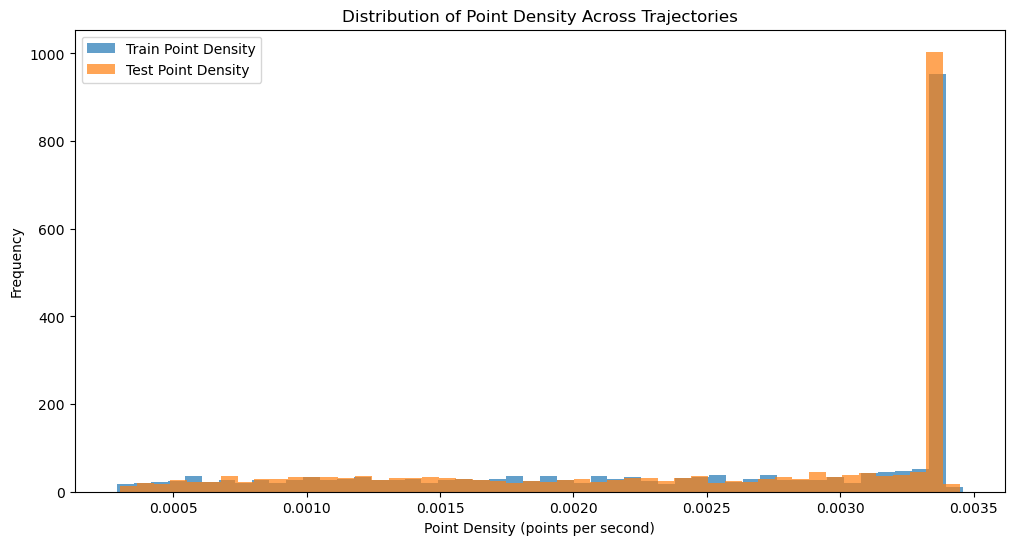

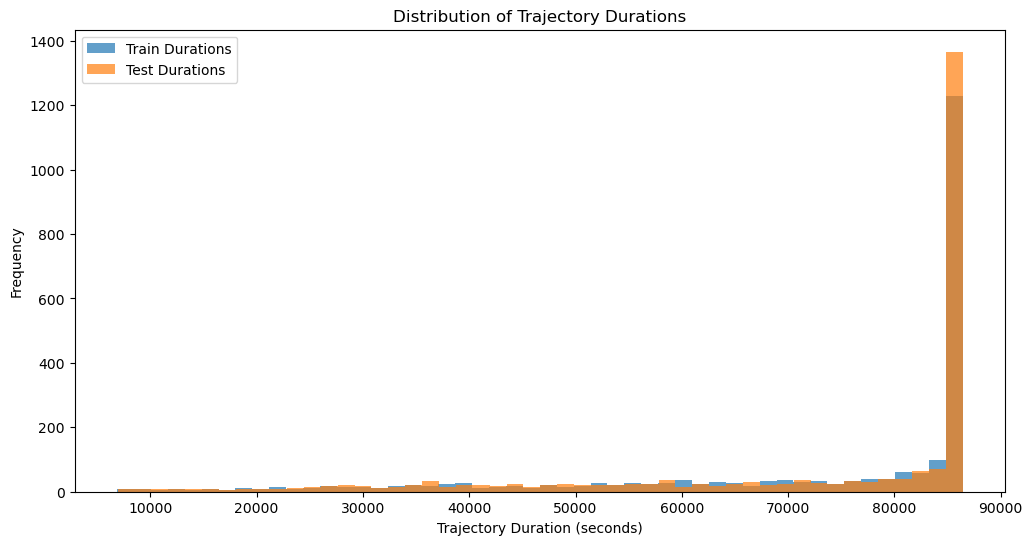

In [14]:
import pandas as pd
import matplotlib.pyplot as plt

# Helper function to calculate time intervals
def calculate_time_intervals(timestamps):
    """Calculate time intervals between consecutive timestamps in seconds."""
    time_intervals = [pd.Series(traj).diff().dt.total_seconds().dropna().tolist() for traj in timestamps]
    return time_intervals

# Calculate time intervals for train and test datasets
train_time_intervals = calculate_time_intervals(train_df["timestamps"])
test_time_intervals = calculate_time_intervals(test_df["timestamps"])

# Flatten time intervals
flat_train_intervals = [item for sublist in train_time_intervals for item in sublist]
flat_test_intervals = [item for sublist in test_time_intervals for item in sublist]

# Numerical statistics for time intervals
train_time_stats = pd.Series(flat_train_intervals).describe()
test_time_stats = pd.Series(flat_test_intervals).describe()

# Add time interval statistics to the DataFrame
time_interval_stats = pd.DataFrame({
    "Train Time Intervals": train_time_stats,
    "Test Time Intervals": test_time_stats
})
print("\nTime Interval Statistics:")
print(time_interval_stats)

# Calculate trajectory duration (in seconds) for train and test datasets
train_df["duration"] = (pd.to_datetime(train_df["end_time"]) - pd.to_datetime(train_df["start_time"])).dt.total_seconds()
test_df["duration"] = (pd.to_datetime(test_df["end_time"]) - pd.to_datetime(test_df["start_time"])).dt.total_seconds()

# Numerical statistics for trajectory durations
train_duration_stats = train_df["duration"].describe()
test_duration_stats = test_df["duration"].describe()

# Add trajectory duration statistics to the DataFrame
duration_stats = pd.DataFrame({
    "Train Durations": train_duration_stats,
    "Test Durations": test_duration_stats
})
print("\nTrajectory Duration Statistics:")
print(duration_stats)

# Calculate point density per trajectory
train_df["point_density"] = train_df["point_count"] / train_df["duration"]
test_df["point_density"] = test_df["point_count"] / test_df["duration"]

# Numerical statistics for point density
point_density_stats = pd.DataFrame({
    "Train Point Density": train_df["point_density"].describe(),
    "Test Point Density": test_df["point_density"].describe()
})
print("\nPoint Density Statistics:")
print(point_density_stats)

# Summary of velocity statistics
train_velocity_stats = train_df["velocities"].apply(lambda x: pd.Series(x).describe()).mean(axis=0)
test_velocity_stats = test_df["velocities"].apply(lambda x: pd.Series(x).describe()).mean(axis=0)

velocity_stats = pd.DataFrame({
    "Train Velocities": train_velocity_stats,
    "Test Velocities": test_velocity_stats
})
print("\nVelocity Statistics:")
print(velocity_stats)

# Summary of orientation statistics
train_orientation_stats = train_df["orientations"].apply(lambda x: pd.Series(x).describe()).mean(axis=0)
test_orientation_stats = test_df["orientations"].apply(lambda x: pd.Series(x).describe()).mean(axis=0)

orientation_stats = pd.DataFrame({
    "Train Orientations": train_orientation_stats,
    "Test Orientations": test_orientation_stats
})
print("\nOrientation Statistics:")
print(orientation_stats)

# Visualize distribution of time intervals
plt.figure(figsize=(12, 6))
plt.hist(flat_train_intervals, bins=50, alpha=0.7, label="Train Intervals")
plt.hist(flat_test_intervals, bins=50, alpha=0.7, label="Test Intervals")
plt.xlabel("Time Interval (seconds)")
plt.ylabel("Frequency")
plt.title("Distribution of Time Intervals Between Timestamps")
plt.legend()
plt.show()

# Visualize point density
plt.figure(figsize=(12, 6))
plt.hist(train_df["point_density"], bins=50, alpha=0.7, label="Train Point Density")
plt.hist(test_df["point_density"], bins=50, alpha=0.7, label="Test Point Density")
plt.xlabel("Point Density (points per second)")
plt.ylabel("Frequency")
plt.title("Distribution of Point Density Across Trajectories")
plt.legend()
plt.show()

# Visualize trajectory duration
plt.figure(figsize=(12, 6))
plt.hist(train_df["duration"], bins=50, alpha=0.7, label="Train Durations")
plt.hist(test_df["duration"], bins=50, alpha=0.7, label="Test Durations")
plt.xlabel("Trajectory Duration (seconds)")
plt.ylabel("Frequency")
plt.title("Distribution of Trajectory Durations")
plt.legend()
plt.show()


Analyzing the number of points in trajectories...

Summary Statistics for Trajectory Point Counts:
count    2354.000000
mean      179.914613
std        89.285804
min        23.000000
25%        98.000000
50%       184.000000
75%       279.000000
max       288.000000
Name: geometry, dtype: float64


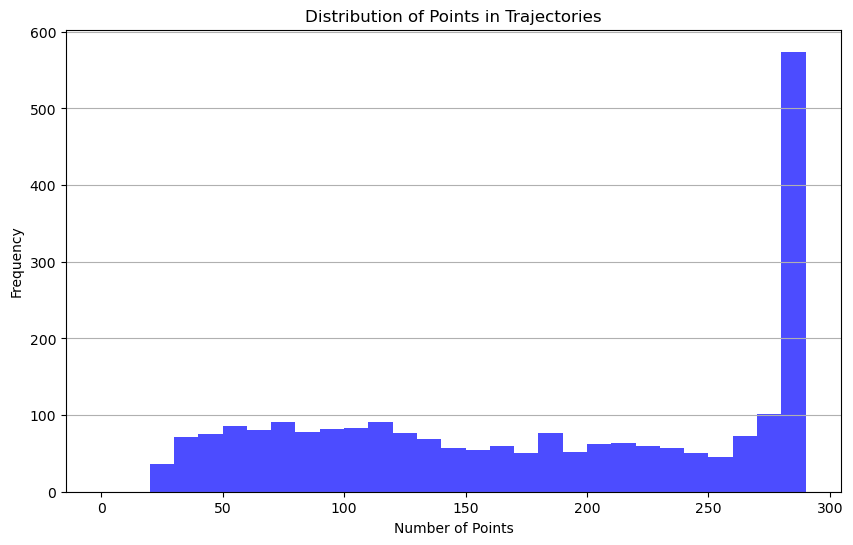


Histogram Data:
    Bin Start  Bin End  Count
0         0.0     10.0    0.0
1        10.0     20.0    0.0
2        20.0     30.0   36.0
3        30.0     40.0   71.0
4        40.0     50.0   75.0
5        50.0     60.0   86.0
6        60.0     70.0   80.0
7        70.0     80.0   91.0
8        80.0     90.0   78.0
9        90.0    100.0   82.0
10      100.0    110.0   83.0
11      110.0    120.0   91.0
12      120.0    130.0   76.0
13      130.0    140.0   69.0
14      140.0    150.0   57.0
15      150.0    160.0   55.0
16      160.0    170.0   59.0
17      170.0    180.0   51.0
18      180.0    190.0   76.0
19      190.0    200.0   52.0
20      200.0    210.0   62.0
21      210.0    220.0   64.0
22      220.0    230.0   59.0
23      230.0    240.0   57.0
24      240.0    250.0   51.0
25      250.0    260.0   45.0
26      260.0    270.0   73.0
27      270.0    280.0  101.0
28      280.0    290.0  574.0
Histogram data saved to trajectory_point_counts_histogram.csv.


In [55]:
def analyze_trajectory_points(df):
    """
    Analyze the number of points in each trajectory and provide summary statistics.
    Outputs histogram plot and numerical data.

    Parameters:
        df (pd.DataFrame): The AIS dataset containing trajectory data.

    Returns:
        pd.DataFrame: A DataFrame with histogram bin edges and counts.
    """
    print("Analyzing the number of points in trajectories...")
    
    # Ensure geometries are valid
    valid_geometries = df[df['is_valid_geometry'] == True]

    # Calculate the number of points in each trajectory
    point_counts = valid_geometries['geometry'].apply(lambda geom: len(geom.coords) if isinstance(geom, LineString) else 0)

    # Print summary statistics
    print("\nSummary Statistics for Trajectory Point Counts:")
    print(point_counts.describe())

    # Plot histogram of point counts
    import matplotlib.pyplot as plt
    plt.figure(figsize=(10, 6))
    bin_edges = range(0, int(point_counts.max()) + 10, 10)  # Bin size of 10 points
    counts, bins, _ = plt.hist(point_counts, bins=bin_edges, color='blue', alpha=0.7)
    plt.title('Distribution of Points in Trajectories')
    plt.xlabel('Number of Points')
    plt.ylabel('Frequency')
    plt.grid(axis='y')
    plt.show()

    # Output histogram data
    histogram_data = pd.DataFrame({
        'Bin Start': bins[:-1],
        'Bin End': bins[1:],
        'Count': counts
    })
    
    print("\nHistogram Data:")
    print(histogram_data)
    
    return histogram_data

# Example Usage
trajectory_point_counts_data = analyze_trajectory_points(train_df)

# Save the histogram data if needed
output_file = "trajectory_point_counts_histogram.csv"
trajectory_point_counts_data.to_csv(output_file, index=False)
print(f"Histogram data saved to {output_file}.")


In [56]:
import pandas as pd
import numpy as np
from shapely.geometry import LineString
from scipy.interpolate import interp1d

def sliding_window_trajectory(coords, time_deltas, window_size, step_size):
    """
    Generates trajectory segments using a sliding window approach.

    Parameters:
        coords (np.array): Coordinates of the trajectory.
        time_deltas (np.array): Time deltas in seconds.
        window_size (int): Duration of each window in seconds.
        step_size (int): Step size for the sliding window in seconds.

    Returns:
        list: A list of segmented geometries (LineString objects).
    """
    segments = []

    for start in range(0, len(time_deltas) - window_size + 1, step_size):
        end = start + window_size
        segment_coords = coords[start:end]
        if len(segment_coords) > 1:
            # Create a LineString for the segment
            segments.append(LineString(segment_coords))
    
    return segments
    
def preprocess_with_sliding_window(df, window_size_seconds, step_size_seconds, interval_seconds=300):
    """
    Preprocess AIS trajectories using sliding window segmentation, keeping the original format.

    Parameters:
        df (pd.DataFrame): The AIS dataset containing trajectory data.
        window_size_seconds (int): Duration of each window in seconds.
        step_size_seconds (int): Step size for sliding window in seconds.
        interval_seconds (int): Time interval between trajectory points in seconds (default: 300).

    Returns:
        pd.DataFrame: A new DataFrame with segmented trajectories and the same columns as the original.
    """
    print("Starting sliding window pre-processing...")

    # Convert window_size and step_size from seconds to points
    window_size_points = window_size_seconds // interval_seconds
    step_size_points = step_size_seconds // interval_seconds

    print(f"Window size (points): {window_size_points}, Step size (points): {step_size_points}")

    # Filter valid geometries
    df = df[df['is_valid_geometry'] == True].copy()
    print(f"Filtered valid geometries: {len(df)} rows")

    segmented_rows = []

    for _, row in df.iterrows():
        geom = row['geometry']
        if not isinstance(geom, LineString):
            print(f"Invalid geometry for MMSI {row['MMSI']}")
            continue

        coords = np.array(geom.coords)
        print(f"MMSI: {row['MMSI']}, Total Points: {len(coords)}, Window Size: {window_size_points}")

        # Check if trajectory has enough points for at least one window
        if len(coords) < window_size_points:
            print(f"Skipping MMSI {row['MMSI']} due to insufficient points.")
            continue

        # Generate trajectory segments
        for start in range(0, len(coords) - window_size_points + 1, step_size_points):
            end = start + window_size_points
            segment_coords = coords[start:end]

            if len(segment_coords) > 1:
                # Create a LineString for the segment
                new_row = row.copy()
                new_row['geometry'] = LineString(segment_coords)
                new_row['segment_id'] = f"{row['MMSI']}_{start}"  # Unique segment identifier
                segmented_rows.append(new_row)

    # Create a new DataFrame with the same columns and segmented trajectories
    segmented_df = pd.DataFrame(segmented_rows)

    print(f"Total trajectory segments generated: {len(segmented_df)}")
    return segmented_df


# Example Usage
# Define window size and step size in seconds
window_size_seconds = 1800  # 30 minutes
step_size_seconds = 900     # 15 minutes


In [57]:
# Assuming df_train is your training DataFrame
segmented_trajectories = preprocess_with_sliding_window(train_df, window_size, step_size)

# Save to a pickle file if needed
output_file = 'segmented_train_df.pkl'
segmented_trajectories.to_pickle(output_file)
print(f"Segmented trajectories saved to {output_file}.")

Starting sliding window pre-processing...
Window size (points): 6, Step size (points): 3
Filtered valid geometries: 2354 rows
MMSI: 338064000, Total Points: 223, Window Size: 6
MMSI: 338189000, Total Points: 51, Window Size: 6
MMSI: 338196000, Total Points: 186, Window Size: 6
MMSI: 338615000, Total Points: 150, Window Size: 6
MMSI: 338878000, Total Points: 286, Window Size: 6
MMSI: 353287000, Total Points: 147, Window Size: 6
MMSI: 366785960, Total Points: 135, Window Size: 6
MMSI: 366816410, Total Points: 182, Window Size: 6
MMSI: 366911650, Total Points: 74, Window Size: 6
MMSI: 366992040, Total Points: 158, Window Size: 6
MMSI: 366997610, Total Points: 288, Window Size: 6
MMSI: 367001310, Total Points: 288, Window Size: 6
MMSI: 367001580, Total Points: 288, Window Size: 6
MMSI: 367059850, Total Points: 150, Window Size: 6
MMSI: 367059850, Total Points: 126, Window Size: 6
MMSI: 367059890, Total Points: 206, Window Size: 6
MMSI: 367081770, Total Points: 91, Window Size: 6
MMSI: 3673

In [58]:
# Assuming df_train is your training DataFrame
segmented_trajectories = preprocess_with_sliding_window(test_df, window_size, step_size)

# Save to a pickle file if needed
output_file = 'segmented_test_df.pkl'
segmented_trajectories.to_pickle(output_file)
print(f"Segmented trajectories saved to {output_file}.")

Starting sliding window pre-processing...
Window size (points): 6, Step size (points): 3
Filtered valid geometries: 2428 rows
MMSI: 210328000, Total Points: 40, Window Size: 6
MMSI: 303517000, Total Points: 247, Window Size: 6
MMSI: 309022000, Total Points: 288, Window Size: 6
MMSI: 309022000, Total Points: 145, Window Size: 6
MMSI: 311032100, Total Points: 103, Window Size: 6
MMSI: 338002000, Total Points: 51, Window Size: 6
MMSI: 338197000, Total Points: 47, Window Size: 6
MMSI: 338281000, Total Points: 238, Window Size: 6
MMSI: 338878000, Total Points: 288, Window Size: 6
MMSI: 356398000, Total Points: 46, Window Size: 6
MMSI: 357982000, Total Points: 288, Window Size: 6
MMSI: 366138000, Total Points: 287, Window Size: 6
MMSI: 366914820, Total Points: 288, Window Size: 6
MMSI: 366956290, Total Points: 274, Window Size: 6
MMSI: 366956290, Total Points: 149, Window Size: 6
MMSI: 366992070, Total Points: 100, Window Size: 6
MMSI: 366997610, Total Points: 233, Window Size: 6
MMSI: 36700

In [184]:
train_df = pd.read_pickle("segmented_train_df.pkl")
test_df = pd.read_pickle("segmented_test_df.pkl")

In [185]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 143752 entries, 0 to 2427
Data columns (total 17 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   MMSI               143752 non-null  int64         
 1   geometry           143752 non-null  object        
 2   mmsi               143752 non-null  float64       
 3   velocities         143752 non-null  object        
 4   orientations       143752 non-null  object        
 5   start_time         143752 non-null  datetime64[ns]
 6   end_time           143752 non-null  datetime64[ns]
 7   point_count        143752 non-null  int64         
 8   vessel_type        143752 non-null  object        
 9   timestamps         143752 non-null  object        
 10  statuses           143752 non-null  object        
 11  max_dist           143752 non-null  float64       
 12  duration           143752 non-null  float64       
 13  point_density      143752 non-null  float64       


In [186]:
train_df = train_df[train_df['geometry'].apply(lambda g: len(set(g.coords)) > 1 if isinstance(g, LineString) else False)]
test_df = test_df[test_df['geometry'].apply(lambda g: len(set(g.coords)) > 1 if isinstance(g, LineString) else False)]


In [187]:
# Function to print sample cells from specific columns
def print_sample_cells(df, column, num_samples=3):
    print(f"\n--- Sample cells from column: {column} ---")
    for i, value in enumerate(df[column].head(num_samples)):
        print(f"Row {i}: {value}")

# Print sample cells from 'orientations' and 'velocities'
#print_sample_cells(train_df, 'orientations')
#print_sample_cells(train_df, 'geometry')

#print_sample_cells(test_df, 'orientations')
#print_sample_cells(test_df, 'velocities')

In [188]:
from shapely.geometry import LineString
from shapely.validation import explain_validity

# Step 1: Validate geometries
def validate_geometry(geometry):
    if not isinstance(geometry, LineString):
        return False  # Not a LineString
    return geometry.is_valid  # Check validity using Shapely

# Add a column to flag valid geometries
train_df['is_valid_geometry'] = train_df['geometry'].apply(validate_geometry)

# Count invalid geometries
invalid_count = train_df['is_valid_geometry'].value_counts().get(False, 0)
print(f"Step 1: Number of invalid geometries: {invalid_count}")

# Inspect a sample of invalid geometries
invalid_geometries = train_df.loc[~train_df['is_valid_geometry'], 'geometry']
if not invalid_geometries.empty:
    print("Invalid geometries samples:")
    print(invalid_geometries.head())


Step 1: Number of invalid geometries: 0


In [189]:
#invalid_geometries.apply(lambda g: len(set(g.coords)) if isinstance(g, LineString) else 0)


In [190]:
import pandas as pd
import numpy as np
from shapely.geometry import LineString
from shapely.validation import explain_validity

def validate_data(df):
    print("\n--- Data Validation ---")
    validation_summary = {}

    # 1. Check for missing values, excluding `geometry_issue`
    print("\n1. Checking for missing values (excluding 'geometry_issue'):")
    
    # Exclude the `geometry_issue` column from the check
    columns_to_check = df.drop(columns=['geometry_issue'], errors='ignore')
    
    # Compute missing values
    missing_values = columns_to_check.isnull().sum()
    
    if (missing_values > 0).any():  # Check if any column has missing values
        print(missing_values[missing_values > 0])  # Display columns with missing values
        validation_summary["missing_values"] = missing_values[missing_values > 0].to_dict()
    else:
        print("No missing values detected.")
        validation_summary["missing_values"] = None


    # 2. Check for duplicate rows
    print("\n2. Checking for duplicate rows:")
    try:
        hashable_df = df.copy()
        for col in df.columns:
            if df[col].apply(type).eq(list).any():
                hashable_df[col] = df[col].apply(str)
        duplicates = hashable_df.duplicated().sum()
        print(f"Number of duplicate rows: {duplicates}")
        validation_summary["duplicate_rows"] = duplicates
    except Exception as e:
        print(f"Error checking duplicates: {e}")
        validation_summary["duplicate_rows"] = f"Error: {e}"

    # 3. Validate data types
    print("\n3. Checking data types:")
    print(df.dtypes)
    validation_summary["data_types"] = df.dtypes.to_dict()

    # 4. Validate `geometry` (LineString)
    print("\n4. Validating geometry data:")
    try:
        def validate_geometry(geometry):
            if not isinstance(geometry, LineString):
                return False, "Not a LineString"
            if not geometry.is_valid:
                return False, explain_validity(geometry)
            return True, None

        validation_results = df['geometry'].apply(validate_geometry)
        df['is_valid_geometry'] = validation_results.apply(lambda x: x[0])
        df['geometry_issue'] = validation_results.apply(lambda x: x[1])

        num_invalid_geometries = (~df['is_valid_geometry']).sum()
        print(f"Number of invalid geometries: {num_invalid_geometries}")
        if num_invalid_geometries > 0:
            examples = df.loc[~df['is_valid_geometry'], ['geometry', 'geometry_issue']].head()
            print(f"Examples of invalid geometries: {examples}")
            validation_summary["invalid_geometries"] = {
                "count": num_invalid_geometries,
                "examples": examples.to_dict(orient='records'),
            }
        else:
            validation_summary["invalid_geometries"] = None
    except Exception as e:
        print(f"Error validating geometry: {e}")
        validation_summary["invalid_geometries"] = f"Error: {e}"

    # 5. Validate and analyze `velocities`
    print("\n5. Validating velocities:")
    try:
        valid_velocities = df['velocities'].apply(
            lambda x: isinstance(x, list) or (isinstance(x, str) and eval(x) is not None)
        )
        invalid_velocities = len(df) - valid_velocities.sum()
        velocity_lengths = df['velocities'].apply(
            lambda x: len(eval(x)) if isinstance(x, str) else len(x) if isinstance(x, list) else 0
        )
        print(f"Velocities - Invalid entries: {invalid_velocities}")
        print(f"Velocities - Min length: {velocity_lengths.min()}, Max length: {velocity_lengths.max()}, Mean length: {velocity_lengths.mean()}")
        
        # Additional statistics for velocities
        flattened_velocities = [
            value for sublist in df['velocities'] if isinstance(sublist, list) for value in sublist
        ]
        velocity_stats = {
            "min": np.min(flattened_velocities),
            "max": np.max(flattened_velocities),
            "mean": np.mean(flattened_velocities),
            "median": np.median(flattened_velocities),
            "std": np.std(flattened_velocities),
            "total_values": len(flattened_velocities),
        }
        print(f"Velocity Statistics: {velocity_stats}")

        validation_summary["velocities"] = {
            "invalid_entries": invalid_velocities,
            "min_length": velocity_lengths.min(),
            "max_length": velocity_lengths.max(),
            "mean_length": velocity_lengths.mean(),
            **velocity_stats,
        }
    except Exception as e:
        print(f"Error validating velocities: {e}")
        validation_summary["velocities"] = f"Error: {e}"

    # 6. Validate and analyze `orientations`
    print("\n6. Validating orientations:")
    try:
        valid_orientations = df['orientations'].apply(
            lambda x: isinstance(x, list) or (isinstance(x, str) and eval(x) is not None)
        )
        invalid_orientations = len(df) - valid_orientations.sum()
        orientation_lengths = df['orientations'].apply(
            lambda x: len(eval(x)) if isinstance(x, str) else len(x) if isinstance(x, list) else 0
        )
        print(f"Orientations - Invalid entries: {invalid_orientations}")
        print(f"Orientations - Min length: {orientation_lengths.min()}, Max length: {orientation_lengths.max()}, Mean length: {orientation_lengths.mean()}")
        
        # Additional statistics for orientations
        flattened_orientations = [
            value for sublist in df['orientations'] if isinstance(sublist, list) for value in sublist
        ]
        orientation_stats = {
            "min": np.min(flattened_orientations),
            "max": np.max(flattened_orientations),
            "mean": np.mean(flattened_orientations),
            "median": np.median(flattened_orientations),
            "std": np.std(flattened_orientations),
            "total_values": len(flattened_orientations),
        }
        print(f"Orientation Statistics: {orientation_stats}")

        validation_summary["orientations"] = {
            "invalid_entries": invalid_orientations,
            "min_length": orientation_lengths.min(),
            "max_length": orientation_lengths.max(),
            "mean_length": orientation_lengths.mean(),
            **orientation_stats,
        }
    except Exception as e:
        print(f"Error validating orientations: {e}")
        validation_summary["orientations"] = f"Error: {e}"

    
    # 7. Time range checks
    print("\n7. Checking timestamp ranges:")
    try:
        start_time_range = (df['start_time'].min(), df['start_time'].max())
        end_time_range = (df['end_time'].min(), df['end_time'].max())
        print(f"Start Time - Min: {start_time_range[0]}, Max: {start_time_range[1]}")
        print(f"End Time - Min: {end_time_range[0]}, Max: {end_time_range[1]}")
        validation_summary["timestamp_ranges"] = {
            "start_time": start_time_range,
            "end_time": end_time_range,
        }
    except Exception as e:
        print(f"Error validating timestamps: {e}")
        validation_summary["timestamp_ranges"] = f"Error: {e}"

    # 8. Summary statistics for numerical columns
    print("\n8. Summary statistics for numerical columns:")
    try:
        stats = df.describe()
        print(stats)
        validation_summary["numerical_summary"] = stats.to_dict()
    except Exception as e:
        print(f"Error summarizing numerical columns: {e}")
        validation_summary["numerical_summary"] = f"Error: {e}"

    # Print Summary
    print("\n--- Validation Summary ---")
    for key, value in validation_summary.items():
        print(f"{key}: {value}")
    print("\n--- Validation Complete ---")

    return validation_summary


In [191]:
# Run the validation function
validate_data(train_df)


--- Data Validation ---

1. Checking for missing values (excluding 'geometry_issue'):
No missing values detected.

2. Checking for duplicate rows:
Number of duplicate rows: 0

3. Checking data types:
MMSI                          int64
geometry                     object
mmsi                        float64
velocities                   object
orientations                 object
start_time           datetime64[ns]
end_time             datetime64[ns]
point_count                   int64
vessel_type                  object
timestamps                   object
statuses                     object
max_dist                    float64
duration                    float64
point_density               float64
is_valid_geometry              bool
geometry_issue               object
segment_id                   object
dtype: object

4. Validating geometry data:
Number of invalid geometries: 0

5. Validating velocities:
Velocities - Invalid entries: 0
Velocities - Min length: 23, Max length: 288, Mean l

{'missing_values': None,
 'duplicate_rows': np.int64(0),
 'data_types': {'MMSI': dtype('int64'),
  'geometry': dtype('O'),
  'mmsi': dtype('float64'),
  'velocities': dtype('O'),
  'orientations': dtype('O'),
  'start_time': dtype('<M8[ns]'),
  'end_time': dtype('<M8[ns]'),
  'point_count': dtype('int64'),
  'vessel_type': dtype('O'),
  'timestamps': dtype('O'),
  'statuses': dtype('O'),
  'max_dist': dtype('float64'),
  'duration': dtype('float64'),
  'point_density': dtype('float64'),
  'is_valid_geometry': dtype('bool'),
  'geometry_issue': dtype('O'),
  'segment_id': dtype('O')},
 'invalid_geometries': None,
 'velocities': {'invalid_entries': np.int64(0),
  'min_length': 23,
  'max_length': 288,
  'mean_length': np.float64(225.2101785883571),
  'min': np.float64(0.0),
  'max': np.float64(15.0),
  'mean': np.float64(2.399273631462211),
  'median': np.float64(0.21223021582733814),
  'std': np.float64(3.2688439506964144),
  'total_values': 30883297},
 'orientations': {'invalid_entries

In [192]:
from shapely.geometry import LineString
from shapely.validation import explain_validity

def validate_geometry(geometry):
    if not isinstance(geometry, LineString):
        return "Not a LineString"
    if not geometry.is_valid:
        return explain_validity(geometry)
    return None

#train_df['geometry_issue'] = train_df['geometry'].apply(validate_geometry)
#train_df['is_valid_geometry'] = train_df['geometry_issue'].isnull()


In [193]:
# Extract rows with geometry issues
geometry_issues = train_df[~train_df['geometry_issue'].isnull()]

# Display unique issues and their counts
issue_summary = geometry_issues['geometry_issue'].value_counts()

print("List of geometry issues and their counts:")
print(issue_summary)

# Optionally, display a few examples of rows with geometry issues
print("\nExamples of rows with geometry issues:")
print(geometry_issues[['MMSI', 'geometry', 'geometry_issue']].head())


List of geometry issues and their counts:
Series([], Name: count, dtype: int64)

Examples of rows with geometry issues:
Empty DataFrame
Columns: [MMSI, geometry, geometry_issue]
Index: []


In [194]:
# Run the validation function
validate_data(test_df)


--- Data Validation ---

1. Checking for missing values (excluding 'geometry_issue'):
No missing values detected.

2. Checking for duplicate rows:
Number of duplicate rows: 0

3. Checking data types:
MMSI                          int64
geometry                     object
mmsi                        float64
velocities                   object
orientations                 object
start_time           datetime64[ns]
end_time             datetime64[ns]
point_count                   int64
vessel_type                  object
timestamps                   object
statuses                     object
max_dist                    float64
duration                    float64
point_density               float64
is_valid_geometry              bool
geometry_issue               object
segment_id                   object
dtype: object

4. Validating geometry data:
Number of invalid geometries: 0

5. Validating velocities:
Velocities - Invalid entries: 0
Velocities - Min length: 24, Max length: 288, Mean l

{'missing_values': None,
 'duplicate_rows': np.int64(0),
 'data_types': {'MMSI': dtype('int64'),
  'geometry': dtype('O'),
  'mmsi': dtype('float64'),
  'velocities': dtype('O'),
  'orientations': dtype('O'),
  'start_time': dtype('<M8[ns]'),
  'end_time': dtype('<M8[ns]'),
  'point_count': dtype('int64'),
  'vessel_type': dtype('O'),
  'timestamps': dtype('O'),
  'statuses': dtype('O'),
  'max_dist': dtype('float64'),
  'duration': dtype('float64'),
  'point_density': dtype('float64'),
  'is_valid_geometry': dtype('bool'),
  'geometry_issue': dtype('O'),
  'segment_id': dtype('O')},
 'invalid_geometries': None,
 'velocities': {'invalid_entries': np.int64(0),
  'min_length': 24,
  'max_length': 288,
  'mean_length': np.float64(226.4874125726062),
  'min': np.float64(0.0),
  'max': np.float64(15.0),
  'mean': np.float64(2.4364807102297936),
  'median': np.float64(0.2),
  'std': np.float64(3.325690490178261),
  'total_values': 32090775},
 'orientations': {'invalid_entries': np.int64(0),


In [195]:
train_df.head()

MMSI                                           geometry         mmsi  \
0  338064000  LINESTRING (-90.20188 29.13611, -90.2018734234...  338064000.0   
0  338064000  LINESTRING (-90.2018604054054 29.1360998648648...  338064000.0   
0  338064000  LINESTRING (-90.20189 29.13608027027027, -90.2...  338064000.0   
0  338064000  LINESTRING (-90.20473743243244 29.140279594594...  338064000.0   
0  338064000  LINESTRING (-90.2040118918919 29.1483505405405...  338064000.0   

                                          velocities  \
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.4938271604938...   
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.4938271604938...   
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.4938271604938...   
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.4938271604938...   
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.4938271604938...   

                                        orientations          start_time  \
0  [57.0, 57.0, 57.0, 57.0, 57.0, 57.0, 239.12345... 2024-03-01 00:00:11   
0  [57.0, 57.0, 57.0, 57.0, 57.0, 57.0, 239.12345... 2024-03-01 00:00:11   
0  [57.0, 57.0, 57.0, 57.0, 57.0, 57.0, 239.12345... 2024-03-01 00:00:11   
0  [57.0, 57.0, 57.0, 57.0, 57.0, 57.0, 239.12345... 2024-03-01 00:00:11   
0  [57.0, 57.0, 57.0, 57.0, 57.0, 57.0, 239.12345... 2024-03-01 00:00:11   

             end_time  point_count vessel_type  \
0 2024-03-01 23:58:51          223       Other   
0 2024-03-01 23:58:51          223       Other   
0 2024-03-01 23:58:51          223       Other   
0 2024-03-01 23:58:51          223       Other   
0 2024-03-01 23:58:51          223       Other   

                                          timestamps  \
0  [2024-03-01 00:00:11, 2024-03-01 00:05:11, 202...   
0  [2024-03-01 00:00:11, 2024-03-01 00:05:11, 202...   
0  [2024-03-01 00:00:11, 2024-03-01 00:05:11, 202...   
0  [2024-03-01 00:00:11, 2024-03-01 00:05:11, 202...   
0  [2024-03-01 00:00:11, 2024-03-01 00:05:11, 202...   

                                            statuses   max_dist  duration  \
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  39.241654   86320.0   
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  39.241654   86320.0   
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  39.241654   86320.0   
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  39.241654   86320.0   
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  39.241654   86320.0   

   point_density  is_valid_geometry geometry_issue    segment_id  
0       0.002583               True           None   338064000_0  
0       0.002583               True           None   338064000_3  
0       0.002583               True           None   338064000_6  
0       0.002583               True           None   338064000_9  
0       0.002583               True           None  338064000_12

In [196]:
train_df.describe()

MMSI          mmsi                     start_time  \
count  1.371310e+05  1.371310e+05                         137131   
mean   3.709238e+08  3.709238e+08  2024-03-15 19:02:08.304766976   
min    2.091560e+08  2.091560e+08            2024-03-01 00:00:00   
25%    3.670598e+08  3.670598e+08            2024-03-08 00:00:05   
50%    3.674934e+08  3.674934e+08            2024-03-15 11:16:13   
75%    3.680183e+08  3.680183e+08            2024-03-23 00:01:11   
max    6.360234e+08  6.360234e+08            2024-03-31 18:40:51   
std    3.980336e+07  3.980336e+07                            NaN   

                            end_time    point_count       max_dist  \
count                         137131  137131.000000  137131.000000   
mean   2024-03-16 16:46:43.901867264     225.210179      38.415201   
min              2024-03-01 03:56:26      23.000000       5.000089   
25%              2024-03-08 23:56:26     176.000000      14.262369   
50%              2024-03-15 23:59:57     261.000000      28.861862   
75%              2024-03-23 23:59:26     288.000000      51.474869   
max              2024-03-31 23:59:59     288.000000     227.887462   
std                              NaN      72.871805      33.268240   

            duration  point_density  
count  137131.000000  137131.000000  
mean    78275.597101       0.002877  
min      6871.000000       0.000290  
25%     77761.000000       0.002583  
50%     86160.000000       0.003334  
75%     86344.000000       0.003336  
max     86399.000000       0.003458  
std     14933.809042       0.000723

In [197]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import pickle
from shapely.geometry import LineString

# Step 1: Extract Features from Geometry
def extract_geometry_features(df):
    """
    Extract latitude/longitude stats and distance traveled from geometry.

    Parameters:
        df (pd.DataFrame): DataFrame containing the geometry column.

    Returns:
        pd.DataFrame: A DataFrame with extracted features.
    """
    features = []
    for geom in df['geometry']:
        if isinstance(geom, LineString) and len(geom.coords) > 1:
            coords = np.array(geom.coords)  # Extract coordinates
            latitudes = coords[:, 1]
            longitudes = coords[:, 0]
            features.append({
                'mean_lat': np.mean(latitudes),
                'mean_lon': np.mean(longitudes),
                'distance_traveled': geom.length  # Length of the LineString
            })
        else:
            # Handle invalid or empty geometries
            features.append({'mean_lat': np.nan, 'mean_lon': np.nan, 'distance_traveled': 0})
    return pd.DataFrame(features)

# Step 2: Normalize Velocities and Orientations
def compute_stats(column_data):
    """
    Compute statistical features (mean, std) from a list of numerical values.

    Parameters:
        column_data (list): A list of numerical values.

    Returns:
        dict: A dictionary with mean and std deviation.
    """
    if column_data and isinstance(column_data, list):
        column_array = np.array(column_data)
        return {
            'mean': np.mean(column_array),
            'std': np.std(column_array)
        }
    return {'mean': 0, 'std': 0}

def extract_velocity_orientation_features(df):
    """
    Extract statistical features (mean, std) for velocities and orientations.

    Parameters:
        df (pd.DataFrame): DataFrame containing velocities and orientations.

    Returns:
        pd.DataFrame: A DataFrame with extracted stats for velocities and orientations.
    """
    features = []
    for _, row in df.iterrows():
        velocity_stats = compute_stats(row['velocities'])
        orientation_stats = compute_stats(row['orientations'])
        features.append({
            'mean_velocity': velocity_stats['mean'],
            'std_velocity': velocity_stats['std'],
            'mean_orientation': orientation_stats['mean'],
            'std_orientation': orientation_stats['std']
        })
    return pd.DataFrame(features)

# Step 3: Combine Features
def extract_combined_features(df):
    """
    Combine extracted features for geometry, velocities, and orientations.

    Parameters:
        df (pd.DataFrame): DataFrame containing the trajectory data.

    Returns:
        pd.DataFrame: A DataFrame with combined features.
    """
    geometry_features = extract_geometry_features(df).reset_index(drop=True)
    velocity_orientation_features = extract_velocity_orientation_features(df).reset_index(drop=True)
    additional_features = df[['max_dist', 'duration', 'point_density']].reset_index(drop=True)
    
    combined_features = pd.concat([
        geometry_features,
        velocity_orientation_features,
        additional_features
    ], axis=1)
    return combined_features


# Step 4: Normalize Features and Save Scaler
def normalize_features_with_scaler(df, save_scaler_path=None):
    """
    Normalize numerical features using Min-Max Scaling and save the scaler.

    Parameters:
        df (pd.DataFrame): DataFrame with numerical features.
        save_scaler_path (str): Optional path to save the scaler.

    Returns:
        pd.DataFrame, MinMaxScaler: Normalized DataFrame and the fitted scaler.
    """
    scaler = MinMaxScaler()
    normalized_data = scaler.fit_transform(df)
    normalized_df = pd.DataFrame(normalized_data, columns=df.columns)
    
    # Save scaler if a path is provided
    if save_scaler_path:
        with open(save_scaler_path, 'wb') as f:
            pickle.dump(scaler, f)
    
    return normalized_df, scaler

# Step 5: Denormalize Features
def denormalize_features(normalized_df, scaler):
    """
    Revert normalized features to their original scale using the scaler.

    Parameters:
        normalized_df (pd.DataFrame): Normalized DataFrame.
        scaler (MinMaxScaler): The fitted scaler used for normalization.

    Returns:
        pd.DataFrame: Denormalized DataFrame.
    """
    denormalized_data = scaler.inverse_transform(normalized_df)
    denormalized_df = pd.DataFrame(denormalized_data, columns=normalized_df.columns)
    return denormalized_df

# Normalize Train and Test DataFrames Separately
print("Processing train_df...")
train_features = extract_combined_features(train_df)
normalized_train_df, train_scaler = normalize_features_with_scaler(train_features, save_scaler_path='train_scaler.pkl')

print("Processing test_df...")
test_features = extract_combined_features(test_df)
normalized_test_df, test_scaler = normalize_features_with_scaler(test_features, save_scaler_path='test_scaler.pkl')

# Save normalized DataFrames
normalized_train_file = 'normalized_train_features.pkl'
normalized_test_file = 'normalized_test_features.pkl'

normalized_train_df.to_pickle(normalized_train_file)
normalized_test_df.to_pickle(normalized_test_file)

print(f"Normalized train features saved to {normalized_train_file}.")
print(f"Normalized test features saved to {normalized_test_file}.")


Processing train_df...
Processing test_df...
Normalized train features saved to normalized_train_features.pkl.
Normalized test features saved to normalized_test_features.pkl.


In [198]:
#train_df = pd.read_pickle("segmented_train_df.pkl")
#test_df = pd.read_pickle("segmented_test_df.pkl")
#normalized_train_df = pd.read_pickle("normalized_train_features.pkl")
#normalized_test_df = pd.read_pickle("normalized_test_features.pkl")

In [199]:
def validate_normalized_data(original_df, normalized_df, scaler, tolerance=1e-9):
    """
    Validate normalized data against the original data.

    Parameters:
        original_df (pd.DataFrame): Original DataFrame before normalization.
        normalized_df (pd.DataFrame): Normalized DataFrame after normalization.
        scaler (MinMaxScaler): The scaler used for normalization.
        tolerance (float): Tolerance for floating-point precision.

    Returns:
        None: Prints validation results.
    """
    print("\n--- Normalized Data Validation ---\n")

    # Step 1: Detailed Bounds Check
    below_zero = (normalized_df < -tolerance)
    above_one = (normalized_df > (1 + tolerance))

    # Count violations
    below_zero_count = below_zero.sum().sum()  # Total count of True values
    above_one_count = above_one.sum().sum()   # Total count of True values

    print(f"Checking for values below 0 (tolerance: {tolerance}):")
    if below_zero_count == 0:
        print("✅ No values below 0.")
    else:
        print(f"❌ Found {below_zero_count} values below 0.")
        print("Sample of below-zero values:")
        print(below_zero[below_zero].stack().head())

    print(f"\nChecking for values above 1 (tolerance: {tolerance}):")
    if above_one_count == 0:
        print("✅ No values above 1.")
    else:
        print(f"❌ Found {above_one_count} values above 1.")
        print("Sample of above-one values:")
        print(above_one[above_one].stack().head())

    # Step 2: Check feature distributions
    print("\nFeature Statistics (Normalized Data):")
    print(normalized_df.describe())

    # Step 3: Cross-validate with original data
    print("\nCross-validating with original data...")
    denormalized_df = denormalize_features(normalized_df, scaler)
    discrepancies = (original_df - denormalized_df).abs()
    max_discrepancy = discrepancies.max().max()
    print(f"Maximum discrepancy between original and denormalized data: {max_discrepancy:.5f}")
    if max_discrepancy < 1e-5:
        print("✅ Denormalization matches the original data accurately.")
    else:
        print("❌ Significant discrepancies found between original and denormalized data.")

    # Step 4: Check for missing or invalid values
    print("\nChecking for missing or invalid values...")
    if normalized_df.isnull().sum().sum() == 0:
        print("✅ No missing values in the normalized data.")
    else:
        print("❌ Missing values found in the normalized data.")
        print(normalized_df.isnull().sum())

    if np.isinf(normalized_df.values).sum() == 0:
        print("✅ No infinite values in the normalized data.")
    else:
        print("❌ Infinite values found in the normalized data.")

    print("\n--- Validation Complete ---")




# Example Usage
# Assuming train_features (original), normalized_train_df, and train_scaler are available
validate_normalized_data(train_features, normalized_train_df, train_scaler)

validate_normalized_data(test_features, normalized_test_df, test_scaler)


--- Normalized Data Validation ---

Checking for values below 0 (tolerance: 1e-09):
✅ No values below 0.

Checking for values above 1 (tolerance: 1e-09):
✅ No values above 1.

Feature Statistics (Normalized Data):
            mean_lat       mean_lon  distance_traveled  mean_velocity  \
count  137131.000000  137131.000000      137131.000000  137131.000000   
mean        0.703962       0.430308           0.010523       0.225593   
std         0.199683       0.214207           0.034266       0.193859   
min         0.000000       0.000000           0.000000       0.000000   
25%         0.665503       0.312641           0.000088       0.070993   
50%         0.755178       0.320420           0.000196       0.160900   
75%         0.830288       0.647068           0.010795       0.333411   
max         1.000000       1.000000           1.000000       1.000000   

        std_velocity  mean_orientation  std_orientation       max_dist  \
count  137131.000000     137131.000000    137131.0000

In [200]:
normalized_train_df.head()

mean_lat  mean_lon  distance_traveled  mean_velocity  std_velocity  \
0  0.757492  0.318409           0.000127       0.114418      0.399332   
1  0.757611  0.318261           0.002186       0.114418      0.399332   
2  0.760015  0.317497           0.010274       0.114418      0.399332   
3  0.763196  0.317856           0.015778       0.114418      0.399332   
4  0.761923  0.319625           0.011203       0.114418      0.399332   

   mean_orientation  std_orientation  max_dist  duration  point_density  
0          0.255906         0.351463  0.153627  0.999007       0.724008  
1          0.255906         0.351463  0.153627  0.999007       0.724008  
2          0.255906         0.351463  0.153627  0.999007       0.724008  
3          0.255906         0.351463  0.153627  0.999007       0.724008  
4          0.255906         0.351463  0.153627  0.999007       0.724008

In [201]:
from sklearn.cluster import KMeans

def cluster_normalized_data(normalized_df, cluster_count):
    """
    Clusters normalized trajectory features using KMeans.

    Parameters:
        normalized_df (pd.DataFrame): Normalized DataFrame of trajectory features.
        cluster_count (int): Number of clusters.

    Returns:
        np.array: Cluster labels for each trajectory.
    """
    print("Starting clustering on normalized data...")
    
    # Convert normalized DataFrame to numpy array for clustering
    features = normalized_df.to_numpy()

    # Apply clustering
    kmeans = KMeans(n_clusters=cluster_count, random_state=42)
    cluster_labels = kmeans.fit_predict(features)

    print("Clustering complete.")
    return cluster_labels

# Number of clusters
cluster_count = 10


In [202]:
# Number of clusters
cluster_count = 10

# Perform clustering on the normalized train data
cluster_labels = cluster_normalized_data(normalized_train_df, cluster_count)

# Add cluster labels back to the original train DataFrame
train_df['cluster'] = np.nan  # Initialize the cluster column with NaN
for idx, label in zip(normalized_train_df.index, cluster_labels):
    if idx in train_df.index:
        train_df.loc[idx, 'cluster'] = label

# Save clustered DataFrame
clustered_train_file = 'clustered_train_df.pkl'
train_df.to_pickle(clustered_train_file)

print(f"Clustered train DataFrame saved as {clustered_train_file}.")


Starting clustering on normalized data...
Clustering complete.
Clustered train DataFrame saved as clustered_train_df.pkl.


In [203]:
train_df.head()

MMSI                                           geometry         mmsi  \
0  338064000  LINESTRING (-90.20188 29.13611, -90.2018734234...  338064000.0   
0  338064000  LINESTRING (-90.2018604054054 29.1360998648648...  338064000.0   
0  338064000  LINESTRING (-90.20189 29.13608027027027, -90.2...  338064000.0   
0  338064000  LINESTRING (-90.20473743243244 29.140279594594...  338064000.0   
0  338064000  LINESTRING (-90.2040118918919 29.1483505405405...  338064000.0   

                                          velocities  \
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.4938271604938...   
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.4938271604938...   
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.4938271604938...   
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.4938271604938...   
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.4938271604938...   

                                        orientations          start_time  \
0  [57.0, 57.0, 57.0, 57.0, 57.0, 57.0, 239.12345... 2024-03-01 00:00:11   
0  [57.0, 57.0, 57.0, 57.0, 57.0, 57.0, 239.12345... 2024-03-01 00:00:11   
0  [57.0, 57.0, 57.0, 57.0, 57.0, 57.0, 239.12345... 2024-03-01 00:00:11   
0  [57.0, 57.0, 57.0, 57.0, 57.0, 57.0, 239.12345... 2024-03-01 00:00:11   
0  [57.0, 57.0, 57.0, 57.0, 57.0, 57.0, 239.12345... 2024-03-01 00:00:11   

             end_time  point_count vessel_type  \
0 2024-03-01 23:58:51          223       Other   
0 2024-03-01 23:58:51          223       Other   
0 2024-03-01 23:58:51          223       Other   
0 2024-03-01 23:58:51          223       Other   
0 2024-03-01 23:58:51          223       Other   

                                          timestamps  \
0  [2024-03-01 00:00:11, 2024-03-01 00:05:11, 202...   
0  [2024-03-01 00:00:11, 2024-03-01 00:05:11, 202...   
0  [2024-03-01 00:00:11, 2024-03-01 00:05:11, 202...   
0  [2024-03-01 00:00:11, 2024-03-01 00:05:11, 202...   
0  [2024-03-01 00:00:11, 2024-03-01 00:05:11, 202...   

                                            statuses   max_dist  duration  \
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  39.241654   86320.0   
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  39.241654   86320.0   
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  39.241654   86320.0   
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  39.241654   86320.0   
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  39.241654   86320.0   

   point_density  is_valid_geometry geometry_issue    segment_id  cluster  
0       0.002583               True           None   338064000_0      1.0  
0       0.002583               True           None   338064000_3      1.0  
0       0.002583               True           None   338064000_6      1.0  
0       0.002583               True           None   338064000_9      1.0  
0       0.002583               True           None  338064000_12      1.0

In [206]:
# Number of clusters
cluster_count = 10

# Perform clustering on the normalized test data
cluster_labels = cluster_normalized_data(normalized_test_df, cluster_count)

# Add cluster labels back to the original test DataFrame
test_df['cluster'] = np.nan  # Initialize the cluster column with NaN
for idx, label in zip(normalized_test_df.index, cluster_labels):
    if idx in test_df.index:
        test_df.loc[idx, 'cluster'] = label

# Save clustered DataFrame
clustered_test_file = 'clustered_test_df.pkl'
test_df.to_pickle(clustered_test_file)

print(f"Clustered test DataFrame saved as {clustered_test_file}.")


Starting clustering on normalized data...
Clustering complete.
Clustered test DataFrame saved as clustered_test_df.pkl.


# SAVEPOINT, load from here upon restart

In [168]:
#train_df = pd.read_pickle("clustered_train_df.pkl")
#test_df = pd.read_pickle("clustered_test_df.pkl")
#normalized_train_df = pd.read_pickle("normalized_train_features.pkl")
#normalized_test_df = pd.read_pickle("normalized_test_features.pkl")

In [205]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 137131 entries, 0 to 2353
Data columns (total 18 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   MMSI               137131 non-null  int64         
 1   geometry           137131 non-null  object        
 2   mmsi               137131 non-null  float64       
 3   velocities         137131 non-null  object        
 4   orientations       137131 non-null  object        
 5   start_time         137131 non-null  datetime64[ns]
 6   end_time           137131 non-null  datetime64[ns]
 7   point_count        137131 non-null  int64         
 8   vessel_type        137131 non-null  object        
 9   timestamps         137131 non-null  object        
 10  statuses           137131 non-null  object        
 11  max_dist           137131 non-null  float64       
 12  duration           137131 non-null  float64       
 13  point_density      137131 non-null  float64       


In [179]:
normalized_train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137131 entries, 0 to 137130
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   mean_lat           137131 non-null  float64
 1   mean_lon           137131 non-null  float64
 2   distance_traveled  137131 non-null  float64
 3   mean_velocity      137131 non-null  float64
 4   std_velocity       137131 non-null  float64
 5   mean_orientation   137131 non-null  float64
 6   std_orientation    137131 non-null  float64
 7   max_dist           137131 non-null  float64
 8   duration           137131 non-null  float64
 9   point_density      137131 non-null  float64
dtypes: float64(10)
memory usage: 10.5 MB


In [207]:
normalized_train_df.describe()

mean_lat       mean_lon  distance_traveled  mean_velocity  \
count  137131.000000  137131.000000      137131.000000  137131.000000   
mean        0.703962       0.430308           0.010523       0.225593   
std         0.199683       0.214207           0.034266       0.193859   
min         0.000000       0.000000           0.000000       0.000000   
25%         0.665503       0.312641           0.000088       0.070993   
50%         0.755178       0.320420           0.000196       0.160900   
75%         0.830288       0.647068           0.010795       0.333411   
max         1.000000       1.000000           1.000000       1.000000   

        std_velocity  mean_orientation  std_orientation       max_dist  \
count  137131.000000     137131.000000    137131.000000  137131.000000   
mean        0.335246          0.542811         0.467115       0.149919   
std         0.155436          0.159705         0.144175       0.149260   
min         0.000000          0.000000         0.000000       0.000000   
25%         0.218822          0.448382         0.378573       0.041556   
50%         0.319086          0.552255         0.472481       0.107058   
75%         0.446890          0.657054         0.556387       0.208512   
max         1.000000          1.000000         1.000000       1.000000   

            duration  point_density  
count  137131.000000  137131.000000  
mean        0.897855       0.816709  
std         0.187781       0.228141  
min         0.000000       0.000000  
25%         0.891384       0.723749  
50%         0.996995       0.960843  
75%         0.999308       0.961697  
max         1.000000       1.000000

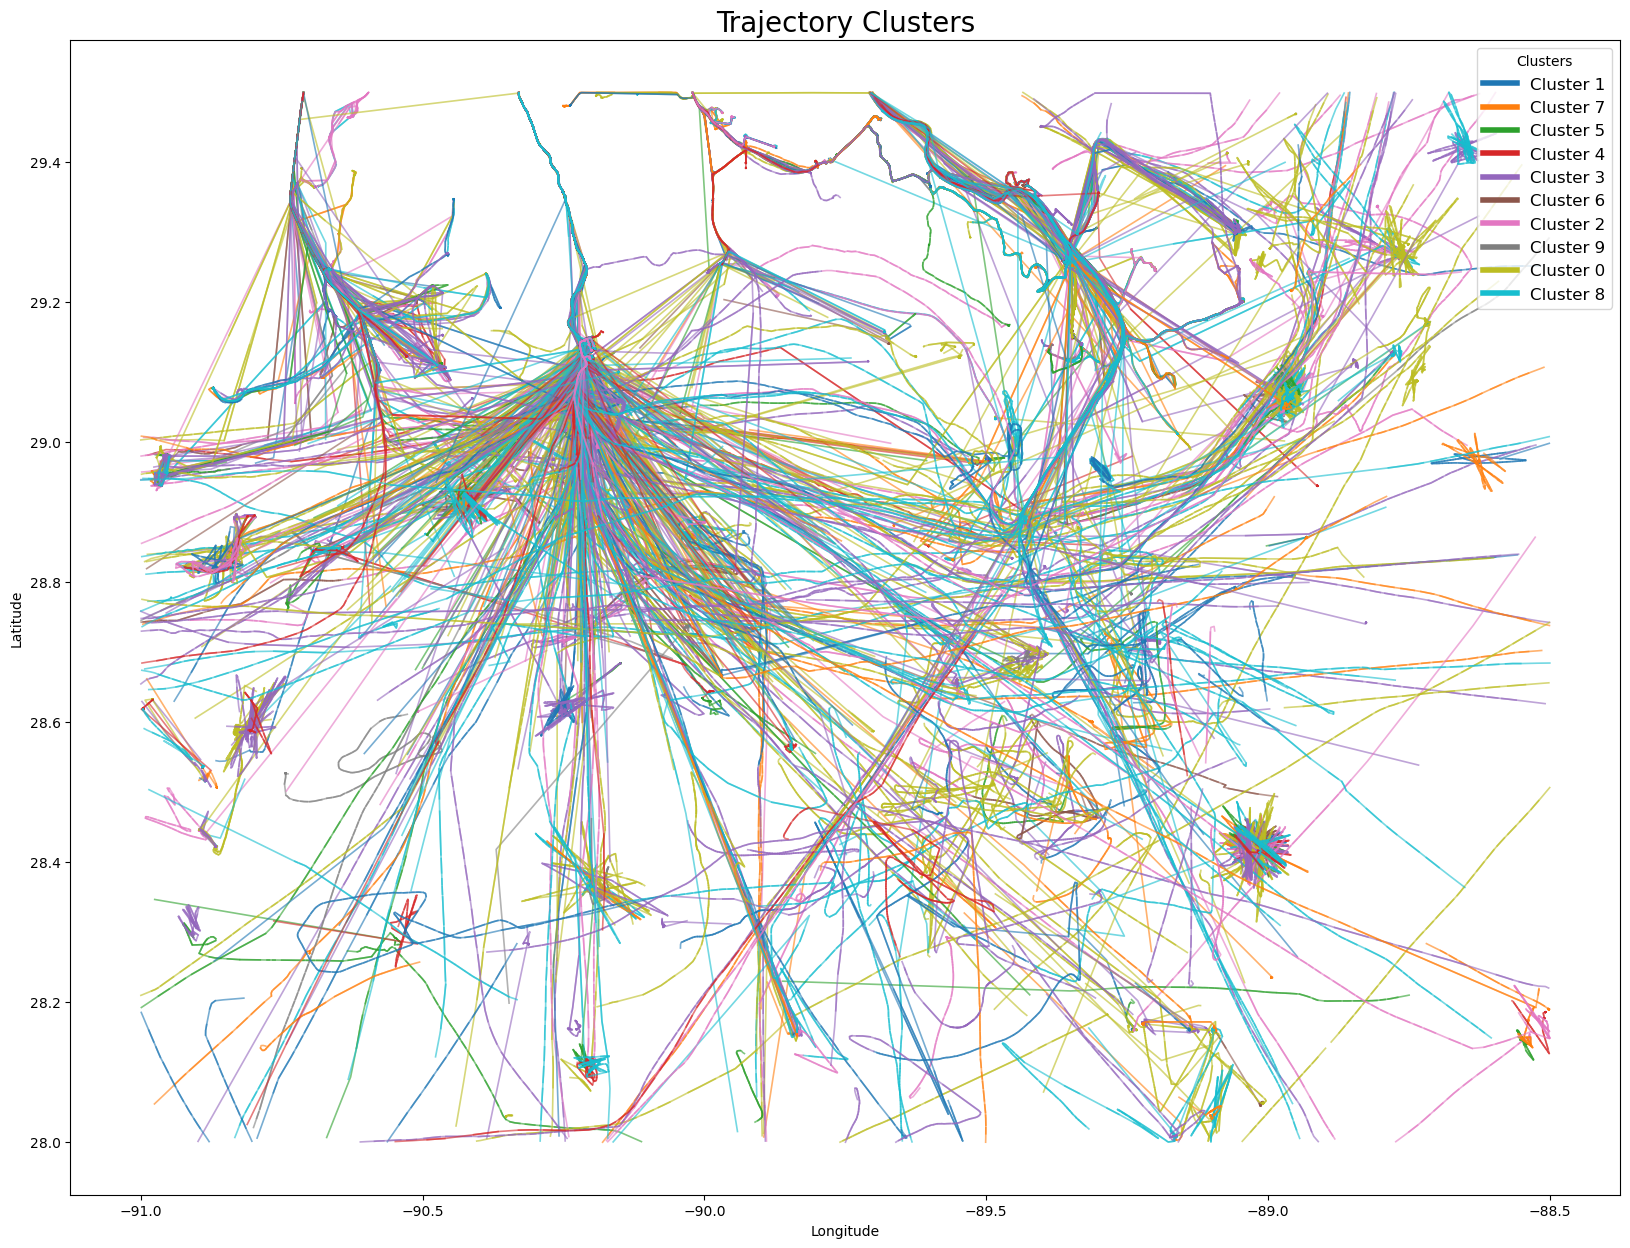

In [208]:
import matplotlib.pyplot as plt
from matplotlib import colormaps  # Correct import for new colormaps API
from shapely.geometry import LineString

def plot_clusters_on_map(df, cluster_column='cluster'):
    """
    Visualize trajectories on a map, coloring them by their cluster labels.
    
    Parameters:
        df (pd.DataFrame): DataFrame containing trajectory data.
        cluster_column (str): Column name representing cluster labels.
    """
    # Ensure cluster column exists
    if cluster_column not in df.columns:
        raise ValueError(f"Column '{cluster_column}' not found in the DataFrame.")
    
    # Extract unique clusters
    clusters = df[cluster_column].dropna().unique()
    num_clusters = len(clusters)
    
    # Generate distinct colors for clusters
    color_map = colormaps.get_cmap('tab10')  # Get the base colormap
    cluster_colors = {cluster: color_map(i / max(clusters)) for i, cluster in enumerate(clusters)}
    
    # Plot trajectories
    fig, ax = plt.subplots(figsize=(20, 15))
    ax.set_title("Trajectory Clusters", fontsize=20)
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    
    for _, row in df.iterrows():
        if not isinstance(row['geometry'], LineString):
            continue  # Skip invalid geometries
        
        cluster = row[cluster_column]
        color = cluster_colors.get(cluster, 'black')  # Default to black if cluster not found
        coords = list(row['geometry'].coords)
        lons, lats = zip(*coords)
        ax.plot(lons, lats, color=color, alpha=0.6, linewidth=1.2)

    # Add a legend for clusters
    handles = [plt.Line2D([0], [0], color=cluster_colors[cluster], lw=4, label=f"Cluster {int(cluster)}")
               for cluster in clusters]
    ax.legend(handles=handles, title="Clusters", loc='upper right', fontsize=12)

    plt.show()

# Example usage
# Assuming `train_df` is the DataFrame containing trajectory data with cluster labels
plot_clusters_on_map(train_df, cluster_column='cluster')


In [209]:
import numpy as np

def flatten_trajectory_positions(df):
    """
    Flattens positional data (latitude and longitude) from trajectories.

    Parameters:
        df (pd.DataFrame): DataFrame containing trajectory geometries.

    Returns:
        np.ndarray: A 2D array where each row is a flattened trajectory.
    """
    flattened_positions = []
    
    for geom in df['geometry']:
        if geom and isinstance(geom, LineString):
            coords = np.array(geom.coords)  # Extract coordinates (lon, lat)
            flattened_positions.append(coords.flatten())
        else:
            # Handle missing or invalid geometries
            flattened_positions.append([])
    
    # Pad trajectories to ensure equal-length feature vectors
    max_len = max(len(traj) for traj in flattened_positions)
    padded_positions = np.array([
        np.pad(traj, (0, max_len - len(traj)), constant_values=np.nan)
        for traj in flattened_positions
    ])

    # Convert to DataFrame
    col_names = [f"coord_{i}" for i in range(padded_positions.shape[1])]
    
    return padded_positions, pd.DataFrame(padded_positions, columns=col_names)

# Example usage
flattened_positions, flattened_df = flatten_trajectory_positions(train_df)
print("Flattened trajectory features shape:", flattened_positions.shape)


Flattened trajectory features shape: (137131, 12)


In [210]:
flattened_df.describe()

coord_0        coord_1        coord_2        coord_3  \
count  137131.000000  137131.000000  137131.000000  137131.000000   
mean      -89.923002      29.055299     -89.922762      29.055951   
std         0.534752       0.299523       0.534681       0.299226   
min       -90.999900      28.000010     -90.997843      28.001319   
25%       -90.216644      28.992270     -90.216540      28.997951   
50%       -90.196860      29.132561     -90.196870      29.132610   
75%       -89.381261      29.246000     -89.380672      29.246000   
max       -88.500030      29.499960     -88.500171      29.499789   

             coord_4        coord_5        coord_6        coord_7  \
count  137131.000000  137131.000000  137131.000000  137131.000000   
mean      -89.922618      29.055986     -89.922546      29.056028   
std         0.534703       0.299246       0.534711       0.299268   
min       -90.996803      28.000359     -90.996685      28.000633   
25%       -90.216490      28.998295     -90.216474      28.998506   
50%       -90.196870      29.132620     -90.196865      29.132625   
75%       -89.381068      29.246000     -89.381429      29.246010   
max       -88.500102      29.499809     -88.500242      29.499795   

             coord_8        coord_9       coord_10       coord_11  
count  137131.000000  137131.000000  137131.000000  137131.000000  
mean      -89.922437      29.056064     -89.922298      29.056071  
std         0.534739       0.299289       0.534776       0.299345  
min       -90.997370      28.000921     -90.999800      28.000070  
25%       -90.216474      28.998522     -90.216485      28.997847  
50%       -90.196869      29.132630     -90.196864      29.132627  
75%       -89.381152      29.246010     -89.381659      29.246000  
max       -88.500171      29.499789     -88.500102      29.499910

In [287]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Step 1: Apply PCA to Flattened Data
def apply_pca(flattened_df, n_components=5):
    """
    Applies PCA to the flattened trajectory data.

    Parameters:
        flattened_df (pd.DataFrame): DataFrame of flattened trajectory data.
        n_components (int): Number of principal components to retain.

    Returns:
        pd.DataFrame: PCA-transformed data.
        PCA: The PCA model for inverse transformations.
    """
    pca = PCA(n_components=n_components)
    pca_transformed = pca.fit_transform(flattened_df)
    pca_df = pd.DataFrame(pca_transformed, columns=[f'pca_{i+1}' for i in range(n_components)])
    return pca_df, pca

# Apply PCA
pca_flattened_df, pca_model = apply_pca(flattened_df, n_components=2)


In [288]:
print("Reduced trajectory features shape:", pca_flattened_df.shape)

Reduced trajectory features shape: (137131, 2)


In [289]:
print("Flattened positions shape:", flattened_positions.shape)


Flattened positions shape: (137131, 12)


Explained Variance Ratio (first 2 components):
  PC1: 0.7639 (Cumulative: 0.7639)
  PC2: 0.2355 (Cumulative: 0.9994)


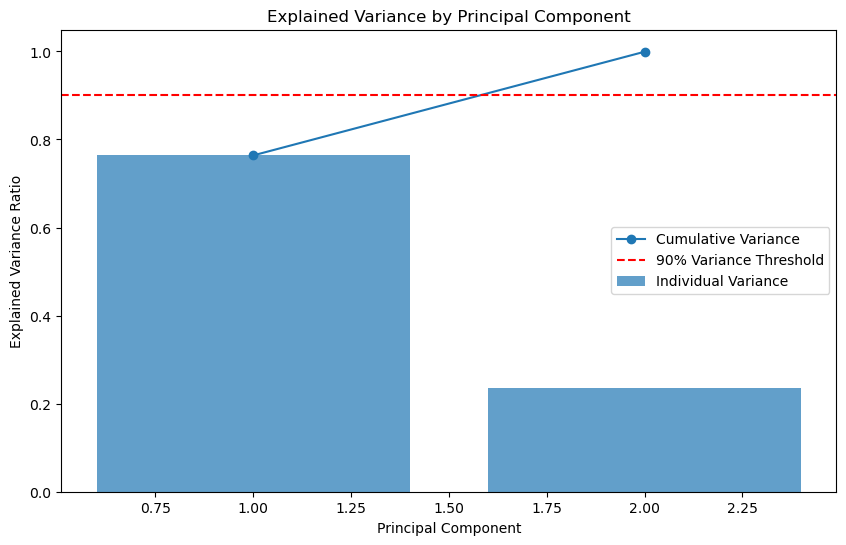

In [290]:
def inspect_variance_ratio(pca_model, n_components):
    """
    Inspect the explained variance ratio of the PCA model.

    Parameters:
        pca_model (PCA): Trained PCA model.
        n_components (int): Number of components to visualize.

    Returns:
        None
    """
    import matplotlib.pyplot as plt
    
    explained_variance = pca_model.explained_variance_ratio_
    cumulative_variance = np.cumsum(explained_variance)

    # Print explained variance
    print(f"Explained Variance Ratio (first {n_components} components):")
    for i in range(n_components):
        print(f"  PC{i+1}: {explained_variance[i]:.4f} (Cumulative: {cumulative_variance[i]:.4f})")

    # Plot explained variance
    plt.figure(figsize=(10, 6))
    plt.bar(range(1, n_components + 1), explained_variance[:n_components], alpha=0.7, label="Individual Variance")
    plt.plot(range(1, n_components + 1), cumulative_variance[:n_components], marker='o', label="Cumulative Variance")
    plt.axhline(0.9, color='r', linestyle='--', label="90% Variance Threshold")
    plt.title("Explained Variance by Principal Component")
    plt.xlabel("Principal Component")
    plt.ylabel("Explained Variance Ratio")
    plt.legend()
    plt.show()

# Example usage
inspect_variance_ratio(pca_model, n_components=2)


In [291]:
# Step 2: Normalize the PCA-Reduced Data
def normalize_data(df):
    """
    Normalizes data using StandardScaler and retains the scaler for inverse transformations.

    Parameters:
        df (pd.DataFrame): DataFrame to normalize.

    Returns:
        pd.DataFrame: Normalized DataFrame.
        StandardScaler: Scaler fitted to the data.
    """
    scaler = StandardScaler()
    normalized = scaler.fit_transform(df)
    normalized_df = pd.DataFrame(normalized, columns=df.columns)
    return normalized_df, scaler

# Normalize PCA-transformed flattened data
normalized_pca_flattened_df, pca_scaler = normalize_data(pca_flattened_df)

# Step 3: Combine Normalized PCA Data and Already Normalized Summary Features
combined_df = pd.concat([normalized_pca_flattened_df, normalized_train_df.reset_index(drop=True)], axis=1)

# Step 4: Save for Clustering
print("Combined DataFrame for Clustering:")
print(combined_df.head())


Combined DataFrame for Clustering:
      pca_1     pca_2  mean_lat  mean_lon  distance_traveled  mean_velocity  \
0 -0.530939  0.200663  0.757492  0.318409           0.000127       0.114418   
1 -0.531651  0.201174  0.757611  0.318261           0.002186       0.114418   
2 -0.535691  0.212790  0.760015  0.317497           0.010274       0.114418   
3 -0.534669  0.228982  0.763196  0.317856           0.015778       0.114418   
4 -0.526191  0.223662  0.761923  0.319625           0.011203       0.114418   

   std_velocity  mean_orientation  std_orientation  max_dist  duration  \
0      0.399332          0.255906         0.351463  0.153627  0.999007   
1      0.399332          0.255906         0.351463  0.153627  0.999007   
2      0.399332          0.255906         0.351463  0.153627  0.999007   
3      0.399332          0.255906         0.351463  0.153627  0.999007   
4      0.399332          0.255906         0.351463  0.153627  0.999007   

   point_density  
0       0.724008  
1      

In [292]:
# Revert normalized PCA data to the original flattened space
#reverted_data = pca_model.inverse_transform(normalized_pca_flattened_df)


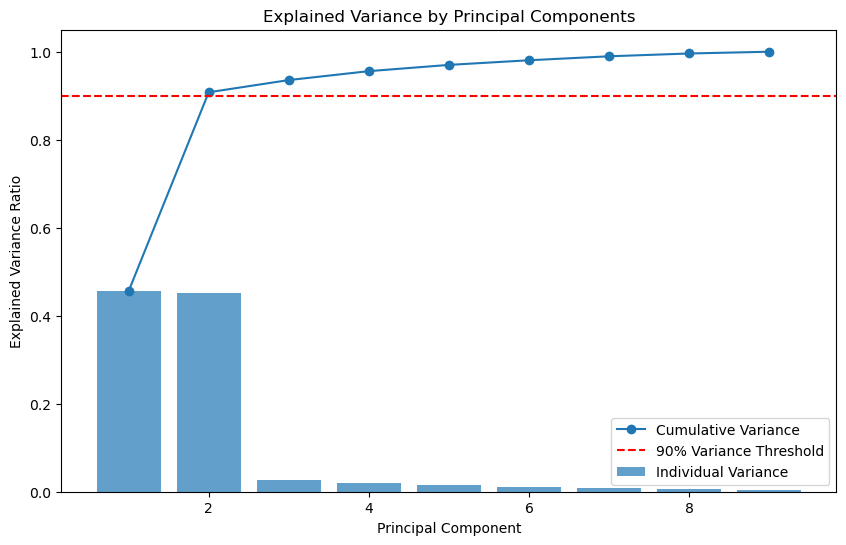

PCA-Transformed DataFrame:
        PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0 -0.567739 -0.115945 -0.061096 -0.110846  0.066489 -0.173974 -0.232571   
1 -0.568629 -0.115887 -0.061172 -0.110795  0.066487 -0.173965 -0.232619   
2 -0.578335 -0.108000 -0.062007 -0.110603  0.066485 -0.173979 -0.233095   
3 -0.586080 -0.093439 -0.063014 -0.110538  0.066412 -0.174065 -0.233574   
4 -0.575861 -0.093506 -0.062579 -0.110722  0.066310 -0.174107 -0.233224   

        PC8       PC9  
0  0.143744  0.085967  
1  0.143656  0.085966  
2  0.143121  0.085844  
3  0.142669  0.085740  
4  0.143047  0.085896  


In [295]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Step 1: Apply PCA
def apply_pca_full(data, n_components=None):
    """
    Applies PCA to the entire combined DataFrame.

    Parameters:
        data (pd.DataFrame): Combined DataFrame with all features.
        n_components (int or None): Number of principal components to retain. If None, keep all components.

    Returns:
        pd.DataFrame: DataFrame with PCA-transformed features.
        PCA: Fitted PCA model.
    """
    pca = PCA(n_components=n_components)
    pca_transformed = pca.fit_transform(data)
    pca_df = pd.DataFrame(
        pca_transformed, 
        columns=[f'PC{i+1}' for i in range(pca_transformed.shape[1])]
    )
    return pca_df, pca

# Apply PCA to the combined data
pca_combined_df, pca_model_combined = apply_pca_full(combined_df, n_components=9)

# Step 2: Analyze Explained Variance
explained_variance = pca_model_combined.explained_variance_ratio_
cumulative_variance = explained_variance.cumsum()

plt.figure(figsize=(10, 6))
plt.bar(range(1, len(explained_variance) + 1), explained_variance, alpha=0.7, label="Individual Variance")
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', label="Cumulative Variance")
plt.axhline(0.9, color='r', linestyle='--', label="90% Variance Threshold")
plt.title("Explained Variance by Principal Components")
plt.xlabel("Principal Component")
plt.ylabel("Explained Variance Ratio")
plt.legend()
plt.show()

# Display PCA-transformed data
print("PCA-Transformed DataFrame:")
print(pca_combined_df.head())


In [281]:
combined_df.head(1)

pca_1     pca_2     pca_3     pca_4     pca_5  mean_lat  mean_lon  \
0 -0.530939  0.200663  0.003091  0.036543  0.016865  0.757492  0.318409   

   distance_traveled  mean_velocity  std_velocity  mean_orientation  \
0           0.000127       0.114418      0.399332          0.255906   

   std_orientation  max_dist  duration  point_density  
0         0.351463  0.153627  0.999007       0.724008

In [296]:
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm  # For progress bar

def gmm_clustering(data, max_clusters=10):
    """
    Perform GMM clustering and determine the optimal number of clusters using BIC.

    Parameters:
        data (pd.DataFrame or np.ndarray): Combined dataset for clustering.
        max_clusters (int): Maximum number of clusters to evaluate.

    Returns:
        tuple: Optimal GMM model and cluster labels.
    """
    bic_scores = []
    silhouette_scores = []
    models = []

    print("Starting GMM clustering...")

    # Loop through the number of clusters
    for n_clusters in tqdm(range(2, max_clusters + 1), desc="Evaluating GMM clusters"):
        print(f"Processing {n_clusters} clusters...")
        #gmm = GaussianMixture(n_components=n_clusters, max_iter=500, random_state=42)
        gmm = GaussianMixture(n_components=n_clusters, max_iter=500, init_params='random', random_state=42)
        gmm.fit(data)
        labels = gmm.predict(data)

        # Compute BIC and Silhouette scores
        bic = gmm.bic(data)
        sil_score = silhouette_score(data, labels)

        bic_scores.append(bic)
        silhouette_scores.append(sil_score)
        models.append((gmm, labels))

        print(f"Clusters: {n_clusters}, BIC: {bic:.2f}, Silhouette: {sil_score:.4f}")

    print("GMM clustering completed.")

    # Plot BIC scores
    plt.figure(figsize=(10, 6))
    plt.plot(range(2, max_clusters + 1), bic_scores, marker='o', label='BIC')
    plt.title("BIC Scores for GMM Clustering")
    plt.xlabel("Number of Clusters")
    plt.ylabel("BIC Score")
    plt.legend()
    plt.show()

    # Plot Silhouette scores
    plt.figure(figsize=(10, 6))
    plt.plot(range(2, max_clusters + 1), silhouette_scores, marker='o', label='Silhouette Score')
    plt.title("Silhouette Scores for GMM Clustering")
    plt.xlabel("Number of Clusters")
    plt.ylabel("Silhouette Score")
    plt.legend()
    plt.show()

    # Select the model with the lowest BIC
    optimal_index = bic_scores.index(min(bic_scores))
    optimal_gmm, optimal_labels = models[optimal_index]

    print(f"Optimal number of clusters: {optimal_index + 2}")
    print(f"Lowest BIC: {min(bic_scores):.2f}")

    return optimal_gmm, optimal_labels


Starting GMM clustering...


Evaluating GMM clusters:   0%|          | 0/9 [00:00<?, ?it/s]

Processing 2 clusters...


Evaluating GMM clusters:  11%|█         | 1/9 [03:48<30:31, 228.90s/it]

Clusters: 2, BIC: -13934.82, Silhouette: 0.1147
Processing 3 clusters...


Evaluating GMM clusters:  22%|██▏       | 2/9 [07:45<27:15, 233.61s/it]

Clusters: 3, BIC: -1254983.30, Silhouette: -0.0055
Processing 4 clusters...


Evaluating GMM clusters:  33%|███▎      | 3/9 [11:41<23:27, 234.61s/it]

Clusters: 4, BIC: -1438729.06, Silhouette: -0.0262
Processing 5 clusters...


Evaluating GMM clusters:  44%|████▍     | 4/9 [15:27<19:16, 231.20s/it]

Clusters: 5, BIC: -16415.10, Silhouette: -0.0475
Processing 6 clusters...


Evaluating GMM clusters:  56%|█████▌    | 5/9 [19:15<15:20, 230.09s/it]

Clusters: 6, BIC: -15480.88, Silhouette: -0.0692
Processing 7 clusters...


Evaluating GMM clusters:  67%|██████▋   | 6/9 [23:21<11:45, 235.30s/it]

Clusters: 7, BIC: -1701360.35, Silhouette: -0.0617
Processing 8 clusters...


Evaluating GMM clusters:  78%|███████▊  | 7/9 [27:30<07:59, 239.95s/it]

Clusters: 8, BIC: -1839757.01, Silhouette: -0.1132
Processing 9 clusters...


Evaluating GMM clusters:  89%|████████▉ | 8/9 [31:38<04:02, 242.49s/it]

Clusters: 9, BIC: -1823280.53, Silhouette: -0.0416
Processing 10 clusters...


Evaluating GMM clusters: 100%|██████████| 9/9 [35:37<00:00, 237.53s/it]

Clusters: 10, BIC: -1896725.30, Silhouette: -0.1185
GMM clustering completed.


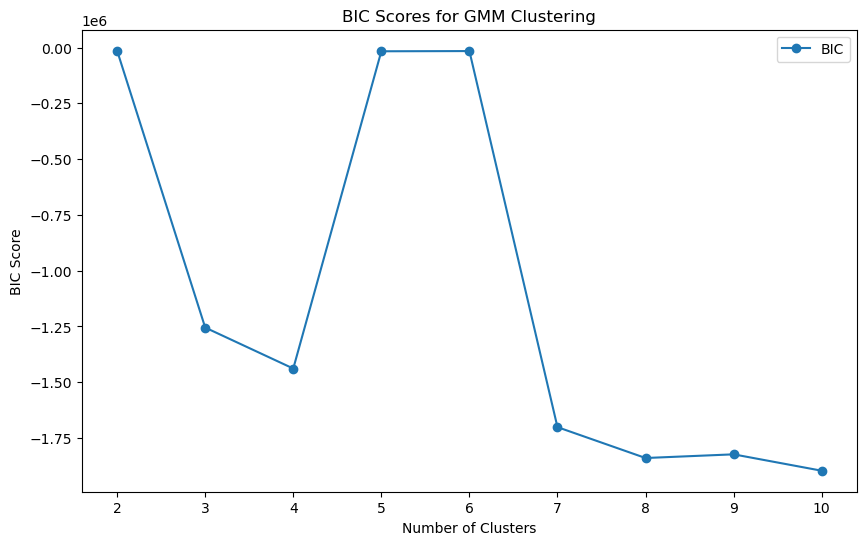

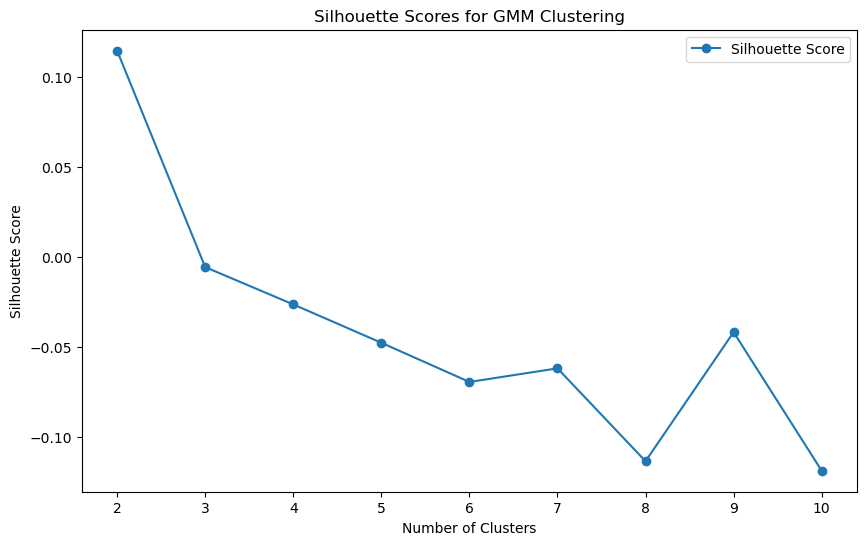

Optimal number of clusters: 10
Lowest BIC: -1896725.30
        PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0 -0.567739 -0.115945 -0.061096 -0.110846  0.066489 -0.173974 -0.232571   
1 -0.568629 -0.115887 -0.061172 -0.110795  0.066487 -0.173965 -0.232619   
2 -0.578335 -0.108000 -0.062007 -0.110603  0.066485 -0.173979 -0.233095   
3 -0.586080 -0.093439 -0.063014 -0.110538  0.066412 -0.174065 -0.233574   
4 -0.575861 -0.093506 -0.062579 -0.110722  0.066310 -0.174107 -0.233224   

        PC8       PC9  GMM_Cluster  
0  0.143744  0.085967            4  
1  0.143656  0.085966            4  
2  0.143121  0.085844            4  
3  0.142669  0.085740            4  
4  0.143047  0.085896            4  


In [297]:
O

In [228]:
# Analyze clusters
cluster_summary = pca_combined_df.groupby('GMM_Cluster').mean()
print("Cluster Summary:")
print(cluster_summary)


Cluster Summary:
                  PC1       PC2       PC3       PC4       PC5       PC6  \
GMM_Cluster                                                               
0            0.086579 -0.478229 -0.918571 -0.599248 -0.083137 -0.137996   
1           -0.561399 -0.154004  0.029263  0.042724  0.014098 -0.170766   
2            1.082205 -0.603738  0.123721 -0.014105 -0.002237  0.009793   
3            0.140364 -0.035264 -0.075198 -0.035127  0.000193 -0.163831   
4           -0.048668  0.261004  0.022936  0.025347 -0.000538  0.100171   
5           -0.564213 -0.132481  0.021084  0.027752  0.010459 -0.033581   
6            0.189259  0.480633  0.044077 -0.001670 -0.001080  0.172874   
7            0.819400 -0.481709  0.053452  0.045822 -0.012752 -0.133942   

                  PC7       PC8       PC9      PC10  
GMM_Cluster                                          
0            0.077108 -0.023094  0.027374 -0.005752  
1           -0.091405 -0.018153 -0.052810  0.008598  
2           -0.0

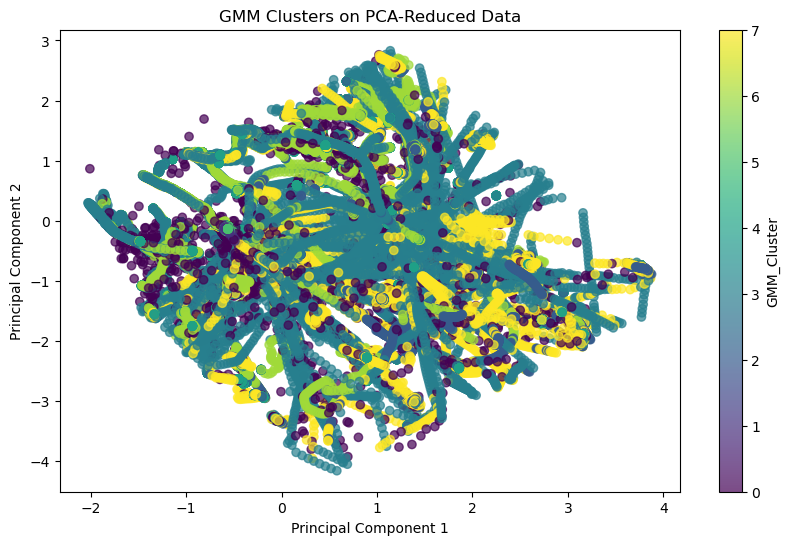

In [230]:
# Print GMM means (centroids) in PCA space
print("Cluster Centroids (PCA space):")
print(optimal_gmm.means_)


Cluster Centroids (PCA space):
[[ 8.65634058e-02 -4.78265017e-01 -9.18609991e-01 -5.99279209e-01
  -8.31394913e-02 -1.37991461e-01  7.71002343e-02 -2.30843466e-02
   2.73710852e-02 -5.74971135e-03  7.00000000e+00]
 [-5.61399888e-01 -1.54003291e-01  2.92326956e-02  4.27185025e-02
   1.40994492e-02 -1.70752755e-01 -9.14254345e-02 -1.81509732e-02
  -5.28125840e-02  8.61744493e-03  3.00000000e+00]
 [ 1.08220537e+00 -6.03737992e-01  1.23720603e-01 -1.41050877e-02
  -2.23688706e-03  9.79276409e-03 -4.69929728e-02  6.36847894e-02
   1.44187662e-02  9.94015034e-03  0.00000000e+00]
 [ 1.40360965e-01 -3.52518839e-02 -7.51767228e-02 -3.51199152e-02
   1.91836885e-04 -1.63837642e-01  2.92656376e-01 -1.26918729e-01
  -4.30081679e-03 -3.26211506e-02  3.96189365e+00]
 [-4.86729679e-02  2.61000992e-01  2.29358038e-02  2.53472818e-02
  -5.37618467e-04  1.00171183e-01 -2.77877433e-02  2.39776263e-02
   3.01081379e-02  1.36741734e-02  7.46355542e+00]
 [-5.64212995e-01 -1.32480668e-01  2.10835747e-02  2.7

In [243]:
pca_combined_df.describe()

PC1           PC2           PC3           PC4           PC5  \
count  1.371310e+05  1.371310e+05  1.371310e+05  1.371310e+05  1.371310e+05   
mean   1.658076e-17  6.632306e-18 -6.839565e-18  2.901634e-18  1.139928e-18   
std    1.024945e+00  1.020122e+00  1.000317e+00  1.000203e+00  1.000014e+00   
min   -2.028114e+00 -4.160380e+00 -3.718707e+01 -2.650777e+01 -2.928703e+01   
25%   -5.877347e-01 -3.468574e-01 -1.046704e-02  9.511920e-03 -1.869685e-02   
50%   -4.924456e-01 -1.143177e-01  1.888547e-02  2.666232e-02  9.337870e-03   
75%    6.871380e-01  8.271036e-01  6.685912e-02  3.419823e-02  1.837509e-02   
max    3.876355e+00  2.829334e+00  4.012805e+01  2.217109e+01  3.792430e+01   

                PC6           PC7           PC8           PC9          PC10  \
count  1.371310e+05  1.371310e+05  1.371310e+05  1.371310e+05  1.371310e+05   
mean  -9.865555e-17 -8.487279e-17 -7.456162e-17 -1.813003e-16  3.378331e-17   
std    2.523859e-01  2.159756e-01  1.808708e-01  1.548980e-01  1.429284e-01   
min   -1.065605e+00 -7.226820e-01 -8.817642e-01 -5.407504e-01 -7.479380e-01   
25%   -1.791241e-01 -7.997158e-02 -9.380411e-02 -1.060298e-01 -6.756587e-02   
50%    4.880626e-02 -1.480085e-02  1.394641e-02  2.643367e-03  4.047372e-03   
75%    2.036212e-01  8.914085e-02  1.206289e-01  1.019755e-01  8.066525e-02   
max    5.304808e-01  8.175084e-01  5.244619e-01  7.441637e-01  6.023550e-01   

         GMM_Cluster  
count  137131.000000  
mean        3.986196  
std         1.582420  
min         0.000000  
25%         3.000000  
50%         4.000000  
75%         5.000000  
max         7.000000

In [244]:
pca_combined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137131 entries, 0 to 137130
Data columns (total 11 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   PC1          137131 non-null  float64
 1   PC2          137131 non-null  float64
 2   PC3          137131 non-null  float64
 3   PC4          137131 non-null  float64
 4   PC5          137131 non-null  float64
 5   PC6          137131 non-null  float64
 6   PC7          137131 non-null  float64
 7   PC8          137131 non-null  float64
 8   PC9          137131 non-null  float64
 9   PC10         137131 non-null  float64
 10  GMM_Cluster  137131 non-null  int64  
dtypes: float64(10), int64(1)
memory usage: 11.5 MB


In [251]:
# Drop the cluster labels if already added to the DataFrame
if 'GMM_Cluster' in pca_combined_df.columns:
    pca_data_to_inverse = pca_combined_df.drop(columns='GMM_Cluster')
else:
    pca_data_to_inverse = pca_combined_df

# Inverse-transform PCA data to reconstruct original features
original_features = pca_model_combined.inverse_transform(pca_data_to_inverse)

In [252]:
# Check the shape of the original and reconstructed features
print("Shape of original combined_df:", combined_df.shape)
print("Shape of reconstructed features:", original_features.shape)


Shape of original combined_df: (137131, 15)
Shape of reconstructed features: (137131, 15)


In [255]:
print(combined_df.isna().sum())  # Check for missing values
print(combined_df.describe())   # Ensure reasonable ranges for all features


pca_1                0
pca_2                0
pca_3                0
pca_4                0
pca_5                0
mean_lat             0
mean_lon             0
distance_traveled    0
mean_velocity        0
std_velocity         0
mean_orientation     0
std_orientation      0
max_dist             0
duration             0
point_density        0
dtype: int64
              pca_1         pca_2         pca_3         pca_4         pca_5  \
count  1.371310e+05  1.371310e+05  1.371310e+05  1.371310e+05  1.371310e+05   
mean  -5.181489e-17 -1.939949e-16 -2.746189e-17  5.057133e-17  1.906788e-17   
std    1.000004e+00  1.000004e+00  1.000004e+00  1.000004e+00  1.000004e+00   
min   -1.981669e+00 -3.720949e+00 -3.983530e+01 -2.602220e+01 -3.471796e+01   
25%   -5.571149e-01 -1.595538e-01 -9.587604e-03  3.116786e-02 -1.305095e-02   
50%   -5.207903e-01  2.022550e-01  4.118705e-03  3.527037e-02  1.663815e-02   
75%    1.014844e+00  6.120490e-01  3.428952e-02  3.918955e-02  3.083919e-02   
max    2.7

In [256]:
print(pca_combined_df.info())  # Ensure no NaNs
print(pca_combined_df.describe())  # Confirm reasonable ranges for principal components


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137131 entries, 0 to 137130
Data columns (total 11 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   PC1          137131 non-null  float64
 1   PC2          137131 non-null  float64
 2   PC3          137131 non-null  float64
 3   PC4          137131 non-null  float64
 4   PC5          137131 non-null  float64
 5   PC6          137131 non-null  float64
 6   PC7          137131 non-null  float64
 7   PC8          137131 non-null  float64
 8   PC9          137131 non-null  float64
 9   PC10         137131 non-null  float64
 10  GMM_Cluster  137131 non-null  int64  
dtypes: float64(10), int64(1)
memory usage: 11.5 MB
None
                PC1           PC2           PC3           PC4           PC5  \
count  1.371310e+05  1.371310e+05  1.371310e+05  1.371310e+05  1.371310e+05   
mean   1.658076e-17  6.632306e-18 -6.839565e-18  2.901634e-18  1.139928e-18   
std    1.024945e+00  1.020122e+00  1

In [257]:
print("Number of components:", pca_model_combined.n_components_)


Number of components: 10


In [258]:
print("Explained variance ratio:", pca_model_combined.explained_variance_ratio_)
print("Cumulative variance explained:", pca_model_combined.explained_variance_ratio_.cumsum())


Explained variance ratio: [0.19803842 0.19617879 0.18863556 0.18859243 0.18852132 0.01200821
 0.00879342 0.00616715 0.00452314 0.0038511 ]
Cumulative variance explained: [0.19803842 0.39421721 0.58285276 0.7714452  0.95996652 0.97197473
 0.98076814 0.9869353  0.99145844 0.99530954]


In [259]:
import numpy as np

# Check for NaNs
print(np.isnan(original_features).sum())  # Should be 0

# Check basic statistics
print(pd.DataFrame(original_features).describe())


0     0
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
11    0
12    0
13    0
14    0
dtype: int64
                 0             1             2             3             4   \
count  1.371310e+05  1.371310e+05  1.371310e+05  1.371310e+05  1.371310e+05   
mean   7.875863e-18 -1.906788e-16 -2.652922e-17  4.393902e-17  1.253920e-17   
std    1.000001e+00  1.000001e+00  1.000003e+00  1.000003e+00  1.000004e+00   
min   -1.984247e+00 -3.721064e+00 -3.983500e+01 -2.602352e+01 -3.471753e+01   
25%   -5.570134e-01 -1.594165e-01 -9.553165e-03  3.120429e-02 -1.315362e-02   
50%   -5.213554e-01  2.022992e-01  3.859386e-03  3.531368e-02  1.652737e-02   
75%    1.015110e+00  6.112484e-01  3.367670e-02  3.953326e-02  3.082022e-02   
max    2.770058e+00  1.787053e+00  3.543694e+01  2.669565e+01  3.668599e+01   

                  5              6              7              8   \
count  137131.000000  137131.000000  137131.000000  137131.000000   
mean        0.703

In [260]:
print(combined_df.head())


      pca_1     pca_2     pca_3     pca_4     pca_5  mean_lat  mean_lon  \
0 -0.530939  0.200663  0.003091  0.036543  0.016865  0.757492  0.318409   
1 -0.531651  0.201174  0.048418  0.027528  0.106438  0.757611  0.318261   
2 -0.535691  0.212790  0.260637 -0.252229  0.260468  0.760015  0.317497   
3 -0.534669  0.228982 -0.128804 -0.226829 -0.476473  0.763196  0.317856   
4 -0.526191  0.223662 -0.355987  0.319180  0.050235  0.761923  0.319625   

   distance_traveled  mean_velocity  std_velocity  mean_orientation  \
0           0.000127       0.114418      0.399332          0.255906   
1           0.002186       0.114418      0.399332          0.255906   
2           0.010274       0.114418      0.399332          0.255906   
3           0.015778       0.114418      0.399332          0.255906   
4           0.011203       0.114418      0.399332          0.255906   

   std_orientation  max_dist  duration  point_density  
0         0.351463  0.153627  0.999007       0.724008  
1         

In [262]:
original_features = pca_model_combined.inverse_transform(pca_combined_df)
print(pd.DataFrame(original_features).head())


         0         1         2         3         4         5         6   \
0 -0.534422  0.203912  0.001800  0.037726  0.016380  0.758226  0.317692   
1 -0.535145  0.204432  0.047119  0.028701  0.105949  0.758347  0.317541   
2 -0.539245  0.216109  0.259300 -0.251073  0.259962  0.760764  0.316765   
3 -0.538114  0.232194 -0.130105 -0.225742 -0.476968  0.763922  0.317147   
4 -0.529584  0.226809 -0.357256  0.320234  0.049750  0.762635  0.318925   

         7         8         9         10        11        12        13  \
0  0.009050  0.180599  0.281240  0.302160  0.436835  0.169726  1.039898   
1  0.008964  0.180839  0.280805  0.302333  0.437132  0.169893  1.040013   
2  0.010511  0.181521  0.278427  0.303517  0.439081  0.171635  1.040717   
3  0.011600  0.179760  0.282147  0.301939  0.436213  0.170770  1.039366   
4  0.007486  0.179986  0.284392  0.300495  0.433941  0.167915  1.038623   

         14  
0  0.709763  
1  0.709697  
2  0.709169  
3  0.709693  
4  0.710426  


In [263]:
# Create DataFrame for reconstructed features
original_df = pd.DataFrame(original_features, columns=combined_df.columns)

# If cluster labels exist in pca_combined_df, add them back to original_df
if 'GMM_Cluster' in pca_combined_df.columns:
    original_df['GMM_Cluster'] = pca_combined_df['GMM_Cluster']

# View the reconstructed data
print(original_df.head())


AttributeError: 'numpy.ndarray' object has no attribute 'columns'

In [265]:
original_df['GMM_Cluster'] = cluster_labels
print(original_df.groupby('GMM_Cluster').mean())


                pca_1     pca_2     pca_3     pca_4     pca_5  mean_lat  \
GMM_Cluster                                                               
0           -0.175985 -0.411416 -0.395634 -0.964822 -0.372600  0.627087   
1           -0.544446  0.167529  0.001935  0.054226  0.022191  0.751283   
2            0.587777 -1.061546  0.081578  0.033680  0.038699  0.478515   
3            0.095711 -0.090273 -0.039875 -0.066258 -0.026790  0.683602   
4            0.094362  0.236149  0.008583  0.035236  0.007317  0.748262   
5           -0.535946  0.180016  0.003534  0.036091  0.017270  0.753534   
6            0.404441  0.293728  0.037664  0.022973  0.020836  0.751601   
7            0.433039 -0.815004  0.010934  0.056854 -0.006689  0.531348   

             mean_lon  distance_traveled  mean_velocity  std_velocity  \
GMM_Cluster                                                             
0            0.389077           0.024260       0.354358      0.360314   
1            0.315231         

In [266]:
original_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137131 entries, 0 to 137130
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   pca_1              137131 non-null  float64
 1   pca_2              137131 non-null  float64
 2   pca_3              137131 non-null  float64
 3   pca_4              137131 non-null  float64
 4   pca_5              137131 non-null  float64
 5   mean_lat           137131 non-null  float64
 6   mean_lon           137131 non-null  float64
 7   distance_traveled  137131 non-null  float64
 8   mean_velocity      137131 non-null  float64
 9   std_velocity       137131 non-null  float64
 10  mean_orientation   137131 non-null  float64
 11  std_orientation    137131 non-null  float64
 12  max_dist           137131 non-null  float64
 13  duration           137131 non-null  float64
 14  point_density      137131 non-null  float64
 15  GMM_Cluster        137131 non-null  int64  
dtypes:

In [275]:
train_df.shape

(137131, 18)

In [276]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 137131 entries, 0 to 2353
Data columns (total 18 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   MMSI               137131 non-null  int64         
 1   geometry           137131 non-null  object        
 2   mmsi               137131 non-null  float64       
 3   velocities         137131 non-null  object        
 4   orientations       137131 non-null  object        
 5   start_time         137131 non-null  datetime64[ns]
 6   end_time           137131 non-null  datetime64[ns]
 7   point_count        137131 non-null  int64         
 8   vessel_type        137131 non-null  object        
 9   timestamps         137131 non-null  object        
 10  statuses           137131 non-null  object        
 11  max_dist           137131 non-null  float64       
 12  duration           137131 non-null  float64       
 13  point_density      137131 non-null  float64       


In [277]:
# Add cluster labels to the original data
train_df['GMM_Cluster'] = original_df['GMM_Cluster']

# Inspect the updated DataFrame
print(train_df.head())

        MMSI                                           geometry         mmsi  \
0  338064000  LINESTRING (-90.20188 29.13611, -90.2018734234...  338064000.0   
0  338064000  LINESTRING (-90.2018604054054 29.1360998648648...  338064000.0   
0  338064000  LINESTRING (-90.20189 29.13608027027027, -90.2...  338064000.0   
0  338064000  LINESTRING (-90.20473743243244 29.140279594594...  338064000.0   
0  338064000  LINESTRING (-90.2040118918919 29.1483505405405...  338064000.0   

                                          velocities  \
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.4938271604938...   
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.4938271604938...   
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.4938271604938...   
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.4938271604938...   
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.4938271604938...   

                                        orientations          start_time  \
0  [57.0, 57.0, 57.0, 57.0, 57.0, 57.0, 239.12345... 2024-03-01 00:00:11   
0  [57.0, 57.0, 57.0, 57.0, 57

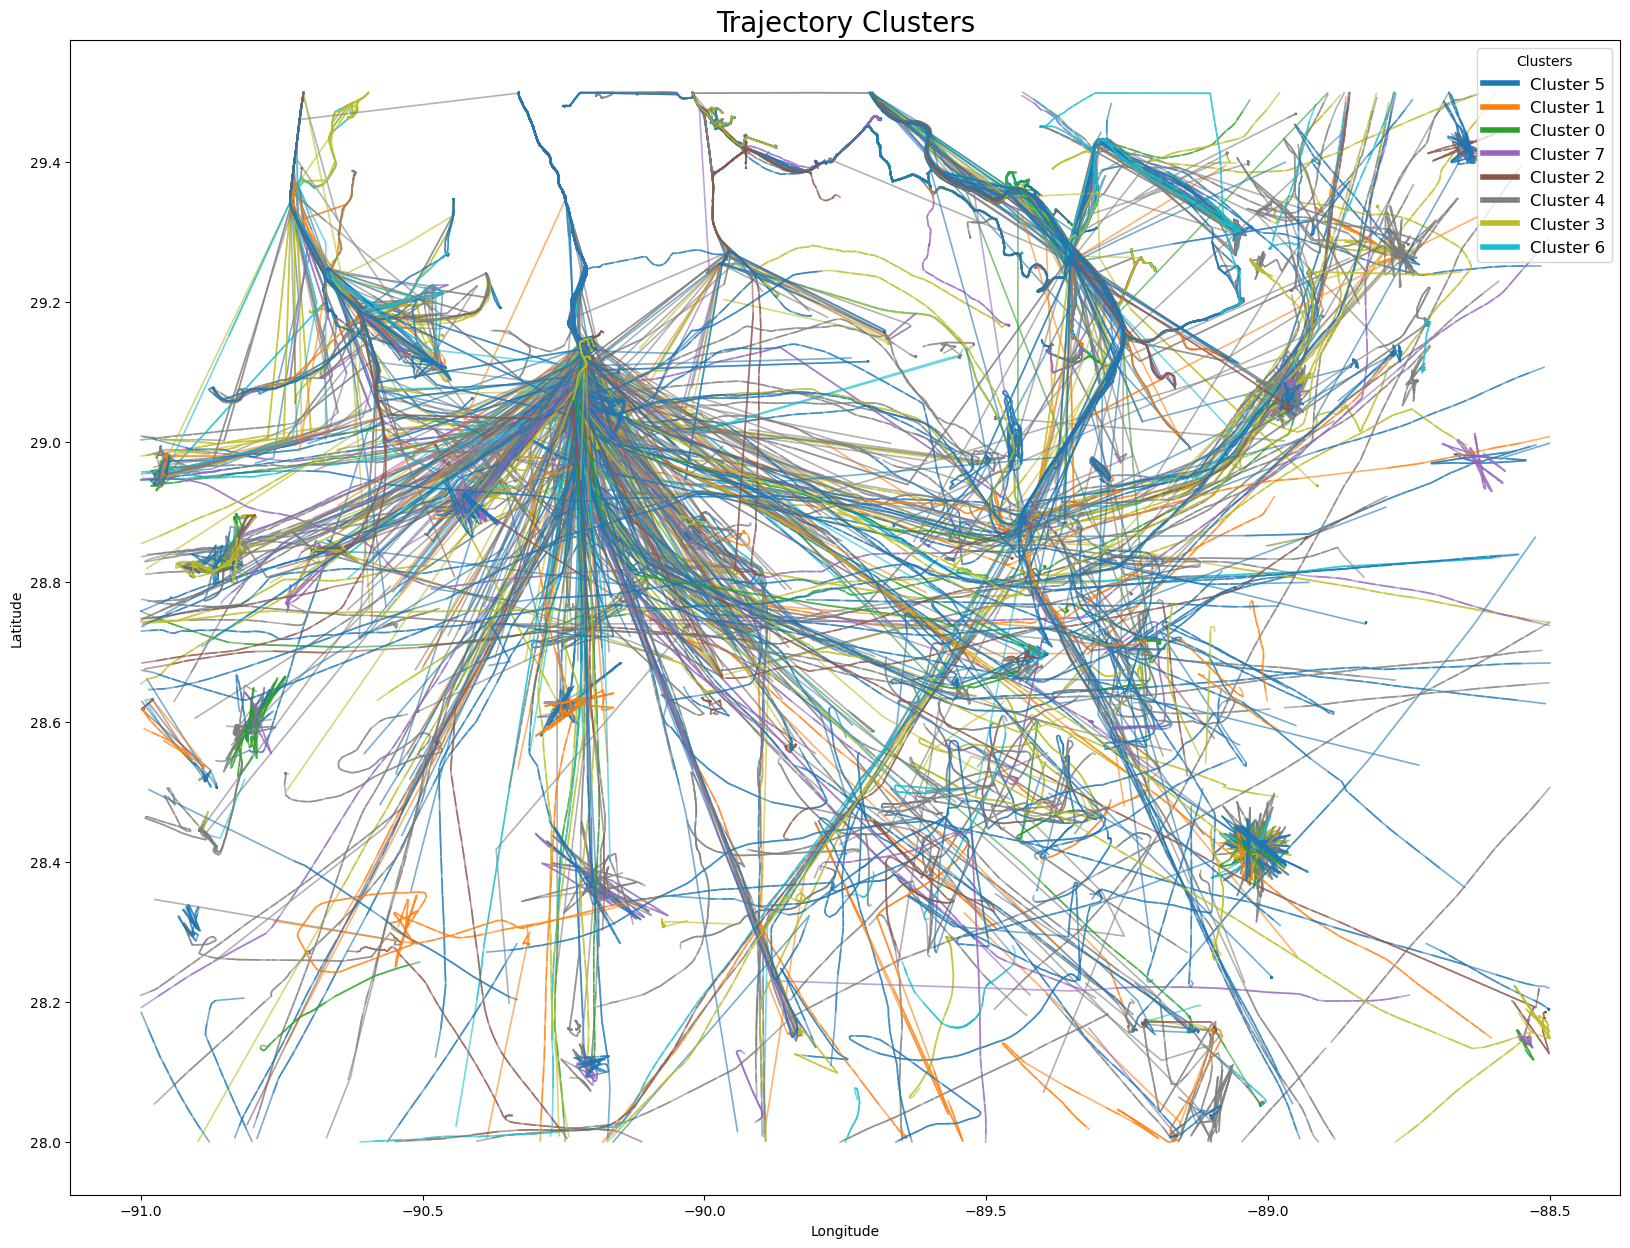

In [278]:
# Example usage
# Assuming `train_df` is the DataFrame containing trajectory data with cluster labels
plot_clusters_on_map(train_df, cluster_column='GMM_Cluster')


# KMEANS FOR COMBINED

In [272]:
print(type(pca_combined_df))  # Check whether it's a pandas DataFrame or NumPy array


<class 'numpy.ndarray'>


In [267]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Determine the number of clusters using KMeans
n_clusters = 10  # Replace with the desired number of clusters
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(pca_combined_df)

# Add cluster labels to the PCA DataFrame
pca_combined_df['Kmeans_Cluster'] = cluster_labels
print(pca_combined_df.head())

# Evaluate clustering with silhouette score
sil_score = silhouette_score(pca_combined_df.drop(columns='Kmeans_Cluster'), cluster_labels)
print(f"Silhouette Score: {sil_score}")


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [ ]:
import matplotlib.pyplot as plt

# Scatter plot of clusters
plt.figure(figsize=(10, 6))
plt.scatter(
    pca_combined_df['PC1'],
    pca_combined_df['PC2'],
    c=pca_combined_df['Kmeans_Cluster'],
    cmap='viridis',
    alpha=0.7
)
plt.title("Clusters Visualized on PCA-Reduced Data")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.colorbar(label="Kmeans_Cluster")
plt.show()


# Calculate cluster statistics



In [ ]:
cluster_summary = pca_combined_df.groupby('Kmeans_Cluster').mean()
print("Cluster Summary:")
print(cluster_summary)

In [ ]:
original_features = pca_model_combined.inverse_transform(pca_combined_df.drop(columns='Kmeans_Cluster'))


In [ ]:
original_df = pd.DataFrame(original_features, columns=combined_data.columns)
print(original_df.head())


In [ ]:
# Save to CSV
pca_combined_df.to_csv('pca_clustered_data.csv', index=False)


# Cluster assessment

In [ ]:
from sklearn.mixture import GaussianMixture

def calculate_bic(data, n_clusters, max_iter=500, init_params='random', random_state=42):
    """
    Calculate the BIC score for GMM clustering.

    Parameters:
        data (pd.DataFrame or np.ndarray): Dataset for clustering.
        n_clusters (int): Number of clusters for GMM.
        max_iter (int): Maximum number of iterations for GMM.
        init_params (str): Initialization method ('kmeans' or 'random').
        random_state (int): Random seed for reproducibility.

    Returns:
        float: BIC score for the given number of clusters.
    """
    gmm = GaussianMixture(
        n_components=n_clusters, 
        max_iter=max_iter, 
        init_params=init_params, 
        random_state=random_state
    )
    gmm.fit(data)
    bic_score = gmm.bic(data)
    return bic_score


In [ ]:
# Evaluate BIC for GMM with different cluster counts
data = pca_combined_df  # Example dataset
bic_scores = []
for n_clusters in range(2, 11):
    bic = calculate_bic(data, n_clusters)
    bic_scores.append(bic)
    print(f"Clusters: {n_clusters}, BIC: {bic:.2f}")

# Plot BIC scores
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(range(2, 11), bic_scores, marker='o')
plt.title("BIC Scores for GMM Clustering")
plt.xlabel("Number of Clusters")
plt.ylabel("BIC Score")
plt.show()


In [279]:
from sklearn.metrics import silhouette_score

def calculate_silhouette(data, labels):
    """
    Calculate the Silhouette Score for given cluster labels.

    Parameters:
        data (pd.DataFrame or np.ndarray): Dataset for clustering.
        labels (np.ndarray): Cluster labels generated by a clustering algorithm.

    Returns:
        float: Silhouette Score for the given clustering.
    """
    sil_score = silhouette_score(data, labels)
    return sil_score


# Number of clusters
cluster_count = 10

# Perform clustering on the normalized train data
cluster_labels = cluster_normalized_data(normalized_train_df, cluster_count)

# Add cluster labels back to the original train DataFrame
train_df['cluster'] = np.nan  # Initialize the cluster column with NaN
for idx, label in zip(normalized_train_df.index, cluster_labels):
    if idx in train_df.index:
        train_df.loc[idx, 'cluster'] = label

# Save clustered DataFrame
clustered_train_file = 'clustered_train_df.pkl'
train_df.to_pickle(clustered_train_file)

print(f"Clustered train DataFrame saved as {clustered_train_file}.")


In [ ]:
# Example: Silhouette Score for KMeans or other clustering
from sklearn.cluster import KMeans

# Perform clustering (KMeans example)
#n_clusters = 5
#kmeans = KMeans(n_clusters=n_clusters, random_state=42)
#cluster_labels = kmeans.fit_predict(data)

# Calculate Silhouette Score
sil_score = calculate_silhouette(data, cluster_labels)
print(f"Silhouette Score for {n_clusters} clusters: {sil_score:.4f}")


In [ ]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

def plot_elbow_method(data, max_clusters=10):
    """
    Plots the Elbow Method for KMeans clustering.

    Parameters:
        data (pd.DataFrame or np.ndarray): Dataset for clustering.
        max_clusters (int): Maximum number of clusters to evaluate.
    """
    wcss = []
    for n_clusters in range(1, max_clusters + 1):
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        kmeans.fit(data)
        wcss.append(kmeans.inertia_)

    plt.figure(figsize=(10, 6))
    plt.plot(range(1, max_clusters + 1), wcss, marker='o')
    plt.title("Elbow Method for Optimal Clusters")
    plt.xlabel("Number of Clusters")
    plt.ylabel("WCSS (Inertia)")
    plt.show()

# Example usage
plot_elbow_method(data, max_clusters=10)


# Compare

In [ ]:
# Comparing GMM and KMeans for 3 clusters
n_clusters = 3

# GMM clustering
gmm = GaussianMixture(n_components=n_clusters, random_state=42)
gmm_labels = gmm.fit_predict(data)
gmm_bic = calculate_bic(data, n_clusters)
gmm_sil_score = calculate_silhouette(data, gmm_labels)

# KMeans clustering
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans_labels = kmeans.fit_predict(data)
kmeans_sil_score = calculate_silhouette(data, kmeans_labels)

# Print results
print(f"GMM: BIC = {gmm_bic:.2f}, Silhouette Score = {gmm_sil_score:.4f}")
print(f"KMeans: Silhouette Score = {kmeans_sil_score:.4f}")


In [162]:


def plot_flattened_trajectories(df, num_trajectories=5):
    """
    Plot trajectories from a DataFrame with flattened positions.

    Parameters:
        df (pd.DataFrame): DataFrame containing flattened trajectory positions.
        num_trajectories (int): Number of trajectories to plot.
    """
    plt.figure(figsize=(10, 10))
    
    for i in range(min(num_trajectories, len(df))):
        row = df.iloc[i].values  # Extract the trajectory row as a numpy array
        coords = row.reshape(-1, 2)  # Reshape into (lon, lat) pairs
        lon, lat = coords[:, 0], coords[:, 1]  # Separate longitude and latitude
        
        # Plot the trajectory
        plt.plot(lon, lat, marker="o", label=f"Trajectory {i+1}")
    
    plt.title("Trajectories on Map")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.legend()
    plt.grid()
    plt.show()

# Example usage
#plot_flattened_trajectories(flattened_df, num_trajectories=100)


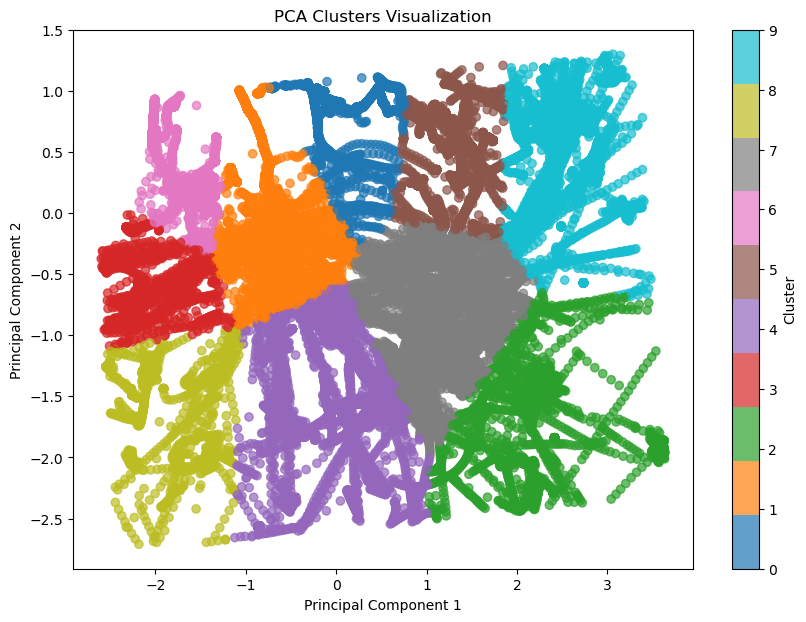

In [138]:
import matplotlib.pyplot as plt

# Scatter plot for first two principal components
plt.figure(figsize=(10, 7))
plt.scatter(
    reduced_positions[:, 0], 
    reduced_positions[:, 1], 
    c=pca_cluster_labels, 
    cmap='tab10', 
    alpha=0.7
)
plt.colorbar(label="Cluster")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("PCA Clusters Visualization")
plt.show()


In [139]:
for cluster in train_df['pca_cluster'].unique():
    print(f"Cluster {cluster} summary:")
    print(train_df[train_df['pca_cluster'] == cluster].describe())


Cluster 1 summary:
               MMSI          mmsi                     start_time  \
count  5.850800e+04  5.850800e+04                          58508   
mean   3.644378e+08  3.644378e+08  2024-03-16 01:48:12.374888704   
min    2.320526e+08  2.320526e+08            2024-03-01 00:00:04   
25%    3.671385e+08  3.671385e+08            2024-03-08 00:00:06   
50%    3.675690e+08  3.675690e+08            2024-03-16 00:39:52   
75%    3.676938e+08  3.676938e+08            2024-03-24 00:00:16   
max    6.360163e+08  6.360163e+08            2024-03-31 11:25:22   
std    1.586609e+07  1.586609e+07                            NaN   

                            end_time   point_count      max_dist  \
count                          58508  58508.000000  58508.000000   
mean   2024-03-16 23:31:44.963799552    213.937068     35.762432   
min              2024-03-01 11:07:27     24.000000      5.000089   
25%              2024-03-08 23:54:27    159.000000     13.165072   
50%              2024-03-16 

In [140]:
train_df.head()

MMSI                                           geometry         mmsi  \
0  338064000  LINESTRING (-90.20188 29.13611, -90.2018734234...  338064000.0   
1  338064000  LINESTRING (-90.2018604054054 29.1360998648648...  338064000.0   
2  338064000  LINESTRING (-90.20189 29.13608027027027, -90.2...  338064000.0   
3  338064000  LINESTRING (-90.20473743243244 29.140279594594...  338064000.0   
4  338064000  LINESTRING (-90.2040118918919 29.1483505405405...  338064000.0   

                                          velocities  \
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.4938271604938...   
1  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.4938271604938...   
2  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.4938271604938...   
3  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.4938271604938...   
4  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.4938271604938...   

                                        orientations          start_time  \
0  [57.0, 57.0, 57.0, 57.0, 57.0, 57.0, 239.12345... 2024-03-01 00:00:11   
1  [57.0, 57.0, 57.0, 57.0, 57.0, 57.0, 239.12345... 2024-03-01 00:00:11   
2  [57.0, 57.0, 57.0, 57.0, 57.0, 57.0, 239.12345... 2024-03-01 00:00:11   
3  [57.0, 57.0, 57.0, 57.0, 57.0, 57.0, 239.12345... 2024-03-01 00:00:11   
4  [57.0, 57.0, 57.0, 57.0, 57.0, 57.0, 239.12345... 2024-03-01 00:00:11   

             end_time  point_count vessel_type  \
0 2024-03-01 23:58:51          223       Other   
1 2024-03-01 23:58:51          223       Other   
2 2024-03-01 23:58:51          223       Other   
3 2024-03-01 23:58:51          223       Other   
4 2024-03-01 23:58:51          223       Other   

                                          timestamps  \
0  [2024-03-01 00:00:11, 2024-03-01 00:05:11, 202...   
1  [2024-03-01 00:00:11, 2024-03-01 00:05:11, 202...   
2  [2024-03-01 00:00:11, 2024-03-01 00:05:11, 202...   
3  [2024-03-01 00:00:11, 2024-03-01 00:05:11, 202...   
4  [2024-03-01 00:00:11, 2024-03-01 00:05:11, 202...   

                                            statuses   max_dist  duration  \
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  39.241654   86320.0   
1  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  39.241654   86320.0   
2  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  39.241654   86320.0   
3  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  39.241654   86320.0   
4  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  39.241654   86320.0   

   point_density  is_valid_geometry geometry_issue    segment_id  cluster  \
0       0.002583               True           None   338064000_0      1.0   
1       0.002583               True           None   338064000_3      1.0   
2       0.002583               True           None   338064000_6      1.0   
3       0.002583               True           None   338064000_9      1.0   
4       0.002583               True           None  338064000_12      1.0   

   pca_cluster  
0            1  
1            1  
2            1  
3            1  
4            1

In [141]:

# Assuming `train_df` is the DataFrame with `pca_cluster` added
pickle_file_path = "pca_clustered_train_df.pkl"

# Save the DataFrame as a pickle file
train_df.to_pickle(pickle_file_path)

print(f"Clustered DataFrame saved successfully to {pickle_file_path}.")


Clustered DataFrame saved successfully to pca_clustered_train_df.pkl.


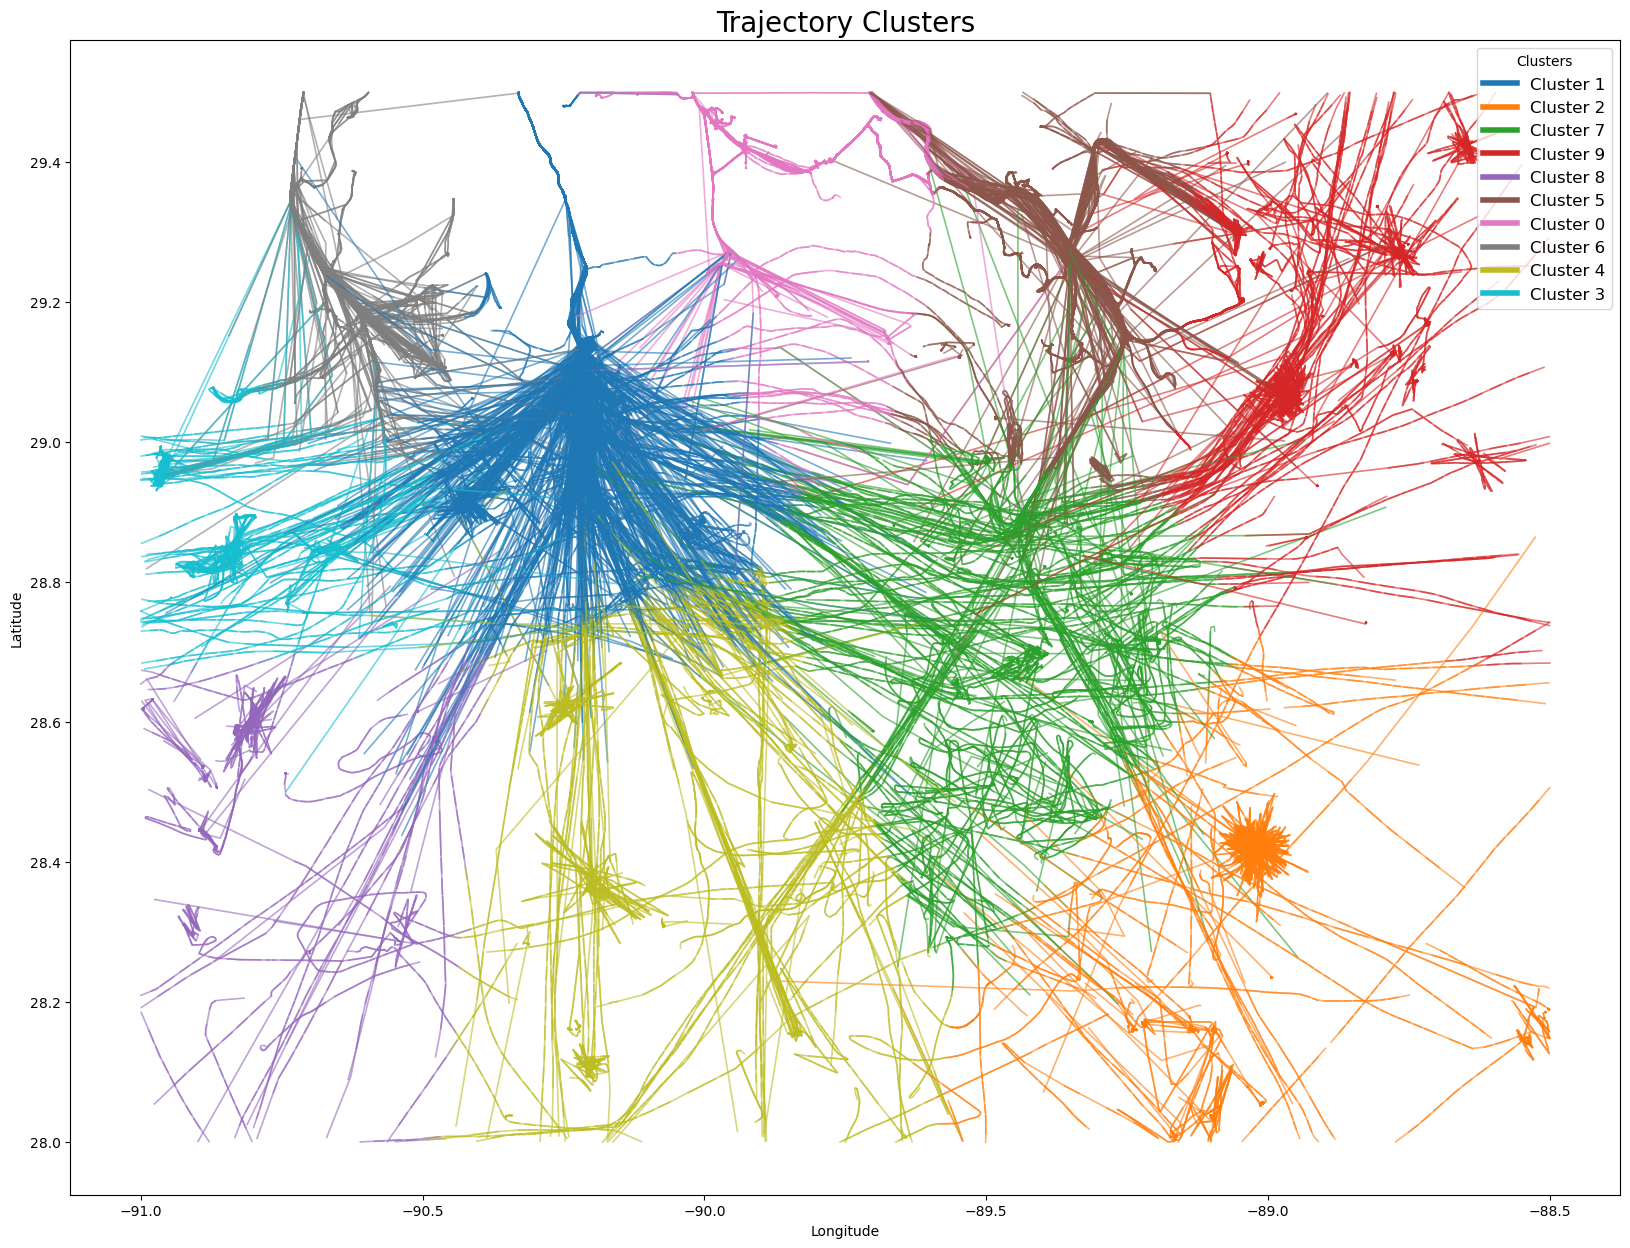

In [142]:
plot_clusters_on_map(train_df, cluster_column='pca_cluster')


In [ ]:
for cluster_id in sorted(train_df['pca_cluster'].unique()):
    print(f"\nCluster {cluster_id} Summary:")
    print(train_df[train_df['pca_cluster'] == cluster_id][['max_dist', 'duration', 'point_density']].describe())
